# **Protein classification on Pfam database**

## Introduction

##### **What is Pfam?**
Pfam is a widely used database in bioinformatics that serves as a valuable resource for molecular biology research.  
It categorizes and stores information about protein families and conserved protein domains across species.  
This resource aids researchers in understanding protein structure and function, predicting unknown functions, and studying evolutionary relationships among proteins, making it a crucial tool in biology and drug discovery.

##### **How does it work?**
Pfam employs sequence alignment and annotation techniques to identify common motifs, structures, and functional domains in proteins. Each entry in Pfam corresponds to a specific protein family, characterized by a set of similar sequences and a domain profile. The families in Pfam are built using Hidden Markov Models.

##### **You said Hidden Markov Models?**
For more details, you can refer to _Krogh (1998)_ or _Eddy (1998)_ (references are below).  
What needs to be understood is that given a list of protein sequences supposed to belong to the same family, the profile Hidden Markov Model (pHMM) will attempt to "describe" these sequences using a Markov Chain.  
Thanks to this, every protein will have a probability of having been generated by this Markov Chain. By defining a threshold, we can determine whether a protein sequence has been generated from that Markov chain or not, and thus whether it belongs to the family

##### **And what about deep learning?**
In this notebook, we will attempt to create a model that excels in protein domains classification.
HMMs use sequential protein patterns to generalize a profile for each protein family.  
As deep learning models also perform well in analyzing sequential data, we will explore their use. The basic idea is to generate an embedding for an amino acid sequence (representing a protein domain) and feed it through a deep learning model to determine the correct family.

##### **But why would we use deep learning if HMMs work?**
HMMs have some limitations:
- They require a significant amount of computational time to run profile hidden Markov models for all the families in a database.
- They do not generalize well to families with a small number of proteins.

Deep learning approaches can address these issues.

## References

#### **References about Hidden Markov Models**  
- Krogh, A. (1998). An Introduction to Hidden Markov Models for Biological Sequences. In S. Salzberg, D. Searls, & S. Kasif (Eds.), New Comprehensive Biochemistry (Vol. 32, pp. 45-63). Elsevier. DOI: 10.1016/S0167-7306(08)60461-5.

- Eddy SR. Profile hidden Markov models. Bioinformatics. 1998;14(9):755-63. doi: 10.1093/bioinformatics/14.9.755. PMID: 9918945.

#### **References about deep learning approaches for protein classification**

- Bileschi, M.L., Belanger, D., Bryant, D., Sanderson, T., Carter, B., Sculley, D., DePristo, M.A., & Colwell, L.J. (2019). Using Deep Learning to Annotate the Protein Universe. Nature Biotechnology. DOI: 10.1101/626507

- Jie Hou, Badri Adhikari, Jianlin Cheng, DeepSF: deep convolutional neural network for mapping protein sequences to folds, Bioinformatics, Volume 34, Issue 8, April 2018, Pages 1295–1303, https://doi.org/10.1093/bioinformatics/btx780

- Yu Li, Sheng Wang, Ramzan Umarov, Bingqing Xie, Ming Fan, Lihua Li, Xin Gao, DEEPre: sequence-based enzyme EC number prediction by deep learning, Bioinformatics, Volume 34, Issue 5, March 2018, Pages 760–769, https://doi.org/10.1093/bioinformatics/btx680

- Seokjun Seo, Minsik Oh, Youngjune Park, Sun Kim, DeepFam: deep learning based alignment-free method for protein family modeling and prediction, Bioinformatics, Volume 34, Issue 13, July 2018, Pages i254–i262, https://doi.org/10.1093/bioinformatics/bty275

- Nils Strodthoff, Patrick Wagner, Markus Wenzel, Wojciech Samek, UDSMProt: universal deep sequence models for protein classification, Bioinformatics, Volume 36, Issue 8, April 2020, Pages 2401–2409, https://doi.org/10.1093/bioinformatics/btaa003

- Sandaruwan PD, Wannige CT. An improved deep learning model for hierarchical classification of protein families. PLoS One. 2021 Oct 20;16(10):e0258625. doi: 10.1371/journal.pone.0258625. PMID: 34669708; PMCID: PMC8528337.

- Nadav Brandes, Dan Ofer, Yam Peleg, Nadav Rappoport, Michal Linial, ProteinBERT: a universal deep-learning model of protein sequence and function, Bioinformatics, Volume 38, Issue 8, March 2022, Pages 2102–2110, https://doi.org/10.1093/bioinformatics/btac020

#### **Other**

- He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).

- Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). Attention is all you need. In Advances in neural information processing systems (pp. 30-38).

## My approach and notebook organization

After examining the data, I noticed that there are approximately 18,000 distinct classes in the dataset. 
My approach involved initially developing an effective architecture using a small subset of data (the top 100 classes) and subsequently scaling it to the entire dataset.  
I experimented with various architectures that have been previously explored in scientific literature for protein classification using deep learning techniques, and then I expanded upon those.

The notebook is divided into the following sections :
- Load data

- Data analysis  
    In this section, I examine potential issues with the dataset, such as class imbalance, sequence length variation, and amino acid distribution.

- Data processing   
    In this section, I preprocess the protein sequences to prepare them for training a deep learning model.

- First test on a subset with the top 100 classes
    - Single model
        I experimented with various model architectures, including:
        - A two-layers feedforward neural network : This simple model was initially developed for testing purposes.  

        - A Convolutional Neural Network (CNN)  
            CNNs are well-suited for processing sequential information.  
            I was also inspired by _Hou et al. (2018)_, _Li et al. (2018)_, _Seo et al. (2018)_, and _Bileschi et al. (2019)_

        - A Residual Neural Network (see _He and al., 2016_)  
            Residual neural networks often improve performances of CNNs.  
            This approach aligns with the work of _Bileschi et al. (2019)_ and _Sandaruwan et al. (2021)_

        - A LSTM-based model  
            As the data is sequential, LSTM might work well on this problem.
            (I was also inspired by _Bileschi et al. (2019)_ and _Strodthoff et al. (2020)_)

        - A Transformer-based model  
            Transformers have demonstrated exceptional results across various domains, including NLP and Computer Vision.  
            My inspiration for this approach was drawn from the work of _Brandes et al. (2022)_.

    The reason why I implemented all these models is because I wanted to compare the performance of the different architectures that have been tried in the literature and have yielded good results.

    - Ensemble method  
        After evaluating the performance of the models mentioned above, I selected the best-performing model and applied an ensemble method to further enhance its predictive capabilities.
        
- On the whole dataset
    - Single CNN  (Accuracy achieved : 96.5%)
    - Ensemble model composed of 5 of these CNN  (Accuracy achieved : 97.22%)

## Results

The best-performing single model was a CNN (see the architecture and hyperparameters detailed in the code below).  
The results improved further when this model was incorporated into an ensemble method.  
It's worth noting that this approach closely resembles the solution proposed by Bileschi et al. (2019), with the exception of certain aspects related to the CNN architecture and hyperparameters.

On the subset composed of the top 100 classes, the model achieves an **accuracy of 99.94%**.  
On the whole dataset, the **accuracy is 97.22%**

# Imports

In [ ]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import product
from tqdm import tqdm

import sklearn
import sklearn.metrics
import sklearn.preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.utils import to_categorical

Place the data in some folder, and indicate the name of this folder.  
Inside of it, there should be a 'train', 'dev', and 'test' folder.

In [2]:
DATASET_PATH = "random_split"

# **Load data**

In [3]:
def load_data(dataset_folder: str = "Data", subfolder: str = "train"):
    """
    Loads data into a dataframe. The data must be found in a folder, and
    eventually separated between sub-folders (e.g. 'train', 'test', 'dev')

    Args:
        dataset_folder (str): Path to the folder containing the data.
                              Default is set to "Data"
        subfolder (str): Specifies the subset of data to load (e.g., 'train', 'test',
                         'dev). Default is set to "train"

    Returns:
        pd.DataFrame: DataFrame containing the combined data from all matching CSV files.
    """
    data = []

    for f in os.listdir(os.path.join(dataset_folder, subfolder)):
        df = pd.read_csv(os.path.join(dataset_folder, subfolder, f))
        data.append(df)

    return pd.concat(data)

In [4]:
df_train = load_data(DATASET_PATH, "train")
df_dev = load_data(DATASET_PATH, "dev")
df_test = load_data(DATASET_PATH, "test")

In [ ]:
df_full = pd.concat([df_train, df_dev, df_test])

# **Data Analysis**

In [ ]:
total_nb_of_samples = len(df_full)
print("Number of samples in total : ", total_nb_of_samples)
print("--- Percentage of the data ---")
for split, df in zip(["Train", "Dev", "Test"], [df_train, df_dev, df_test]):
    print(f"{split} : {len(df) / total_nb_of_samples * 100: .1f} %")

Number of samples in total :  1339083

--- Percentage of the data ---

Train :  81.2 %

Dev :  9.4 %

Test :  9.4 %


In [ ]:
df_train.head(3)

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,MORN_2,Q8EI47_SHEON/428-449,PF07661.13,LHGEFRNQTSSGQLLELI.NFNH,LHGEFRNQTSSGQLLELINFNH
1,Plexin_cytopl,H2TB23_TAKRU/1240-1793,PF08337.12,.MPFLDYKTYTDCNFFLPSKDGAND......AMITRKLQIPE.......,MPFLDYKTYTDCNFFLPSKDGANDAMITRKLQIPEARRAIVAQALN...
2,RT_RNaseH,H3H8E9_PHYRM/405-501,PF17917.1,DYSRRFHVFADAS.GH.QIGGVIVQ........................,DYSRRFHVFADASGHQIGGVIVQGRRILACFSRSMTDTQKKYSTME...


First, I will check whether the data is correctly labelled.  
In particular, I will check :
- whether all the different families are present in the train dataset
- whether a single family_accession is always matched with the same family_id, and vice versa

## a) Analysis of the labels

#### Check whether there exist some family_accession that are not in df_train

In [ ]:
assert len(df_full["family_accession"].unique()) == len(df_train["family_accession"].unique()), "Some family_accession are missing in 'train'"
print("OK - No family_accession is missing in 'train'")

OK - No family_accession is missing in 'train'


#### Check whether each family_id is associated with a unique family_accession, and vice versa

In [ ]:
assert df_full.groupby("family_id")["family_accession"].nunique().max() == 1, "There exists a family id that has multiple family_accession"
assert df_full.groupby("family_accession")["family_id"].nunique().max() == 1, "There exists a family_accession that has multiple family_id"
print("OK - Each family_id is associated with a unique family_accession, and vice versa")

OK - Each family_id is associated with a unique family_accession, and vice versa


#### Checking whether a same family_accession has different versions (PFxxxxx.y, i.e there exists a same xxxxxx that has different y)

In [ ]:
df_full["accession_number"] = df_full["family_accession"].apply(lambda s: str(s.split('.')[0][2:]))
df_full["version"] = df_full["family_accession"].apply(lambda s: str(s.split('.')[1]))

assert df_full.groupby("accession_number")["version"].nunique().max() == 1, "There exists an accession_number that has different versions"
print("OK - Each accession number is associated to a unique version")

OK - Each accession number is associated to a unique version


Conclusion : We can use either family_id or family_accession for the labels.  

Now, let us analyze the labels and the sequences

### Analysis of the labels distribution

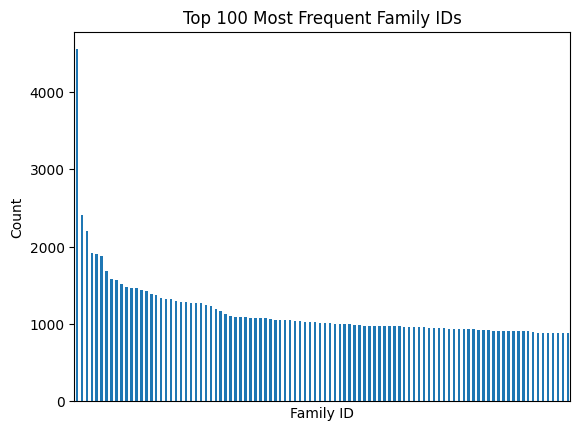

In [ ]:
nb_families_to_plot = 100

family_id_counts = df_full['family_id'].value_counts()
top_family_id_counts = family_id_counts.head(nb_families_to_plot)

top_family_id_counts.plot(kind='bar')
plt.title(f'Top {nb_families_to_plot} Most Frequent Family IDs')
plt.xlabel('Family ID')
plt.ylabel('Count')
plt.xticks([])
plt.show()

In [ ]:
family_id_counts.describe()

count    17929.000000
mean        74.688103
std        144.505273
min          1.000000
25%          9.000000
50%         26.000000
75%         80.000000
max       4545.000000
Name: family_id, dtype: float64

In [ ]:
thresholds = [(100, np.inf), (10, 99), (2, 9), (1, 1)]

print("Number of familes that have :")
for low, high in thresholds:
    count = len(family_id_counts[(family_id_counts >= low) & (family_id_counts <= high)])

    if low == high:
        print(f"- Exactly {low} samples : {count}")
    elif high == np.inf:
        print(f"- More than {low} samples : {count}")
    else:
        print(f"- Between {low} and {high} samples : {count}")

Number of familes that have :

- More than 100 samples : 3571

- Between 10 and 99 samples : 9500

- Between 2 and 9 samples : 4351

- Exactly 1 samples : 507


### Analysis of the number of families per dataest (train, dev, test)

In [ ]:
num_unique_family_train = df_train['family_id'].nunique()
num_unique_family_dev = df_dev['family_id'].nunique()
num_unique_family_test = df_test['family_id'].nunique()
print("-- Number of families --")
print("Train : ", num_unique_family_train)
print("Dev : ", num_unique_family_dev)
print("Test : ", num_unique_family_test)

-- Number of families --

Train :  17929

Dev :  13071

Test :  13071


We observe that there are some families in the train dataset that are not in the test dataset.  
It might make prediction on the test dataset harder, because there will be much more families.

Conclusion: The dataset is unbalanced.  

We will attempt to construct a model using the top 100 classes, and we will try at the end to extend our model to the other classes.  

## b) Analysis of the sequences

#### Analysis of the length of the sequences

(0.0, 800.0)

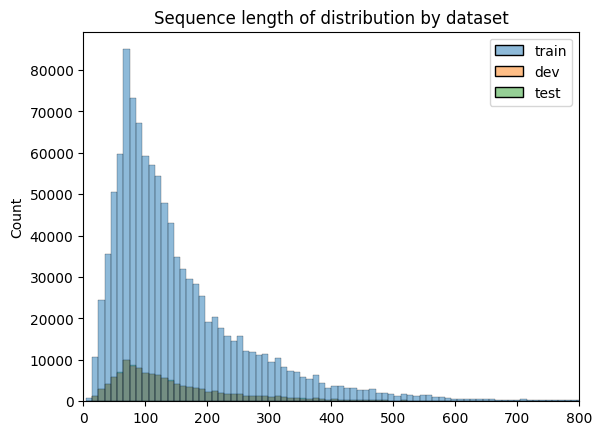

In [ ]:
all_sequence_lengths = []
split_types = []
for split, df in zip(["train", "dev", "test"], [df_train, df_dev, df_test]):
    sequences_lengths = df['sequence'].apply(len).to_list()
    nb_sequences = len(sequences_lengths)
    all_sequence_lengths += sequences_lengths
    split_types += (nb_sequences * [split])

sns.histplot(x=all_sequence_lengths, hue=split_types, bins=200)
plt.title("Sequence length of distribution by dataset")
plt.xlim((0,800))

In [ ]:
df_full["sequence"].apply(len).describe()

count    1.339083e+06
mean     1.551566e+02
std      1.197877e+02
min      4.000000e+00
25%      7.600000e+01
50%      1.190000e+02
75%      1.950000e+02
max      2.037000e+03
Name: sequence, dtype: float64

Most of the sequences have less than 300-400 amino acids.  
Based on these observations, we will truncate the sequences to some value between 300 and 600.

#### Qualitative analysis of the sequences of the same family

Let's examine the sequences of a specific family to determine whether it's easy to identify any patterns, as humans would.

In [ ]:
family_id = "LRR_1"
small_df = df_full[df_full["family_id"] == family_id].reset_index(drop=True)
small_df.head(2)

,family_id,sequence_name,family_accession,aligned_sequence,sequence,accession_number,version
0,LRR_1,FMOD_BOVIN/130-154,PF00560.33,GLLWI....A......L...........HGNQ.....IT..........,GLLWIALHGNQITSDKVGKKVFSKL,00560,33
1,LRR_1,Q9EME3_AMEPV/190-210,PF00560.33,NLKNL....I......F...........HKTN.....I...........,NLKNLIFHKTNINSLLDIYNL,00560,33


In [ ]:
text = ""
for index, row in small_df[:5].iterrows():
    new_text = f"""--- Protein n° {index+1} ---\nSequence : {row["sequence"]}\nAligned sequence : {row["aligned_sequence"]}\n\n"""
    text = text + new_text

print(text)

--- Protein n° 1 ---

Sequence : GLLWIALHGNQITSDKVGKKVFSKL

Aligned sequence : GLLWI....A......L...........HGNQ.....IT...............SDKVGKKV...FS..........K.L



--- Protein n° 2 ---

Sequence : NLKNLIFHKTNINSLLDIYNL

Aligned sequence : NLKNL....I......F...........HKTN.....I.................N..SLLD...IY..........N.L



--- Protein n° 3 ---

Sequence : SLLRLSLYNNCICDVGAESLARV

Aligned sequence : SLLRL....S......L...........YNNC.....I.................CDVGAES...LA..........R.V



--- Protein n° 4 ---

Sequence : RLKYLSICNTGIHKLPDVTKIF

Aligned sequence : RLKYL....S......I...........CNTG.....I..................HKLPDV...TK..........I.F



--- Protein n° 5 ---

Sequence : GLRYLILECPQITQIPDSLGNL

Aligned sequence : GLRYL...........I...........LECP.....Q.................ITQIPDS...LG..........N.L






As a human, it appears challenging to identify a pattern from the list of sequences, but it becomes more manageable with the aligned sequences.  
We might consider whether we could utilize these aligned sequences for our model.  

However, it's important to note that the aligned sequences are generated using HMMs.  
Since the objective is to enhance the current method (Hidden Markov Models), it would necessitate generating the aligned sequences directly from the sequences themselves.  
This could serve as a topic for future research.

## c) Analysis of the frequency of all the amino acids

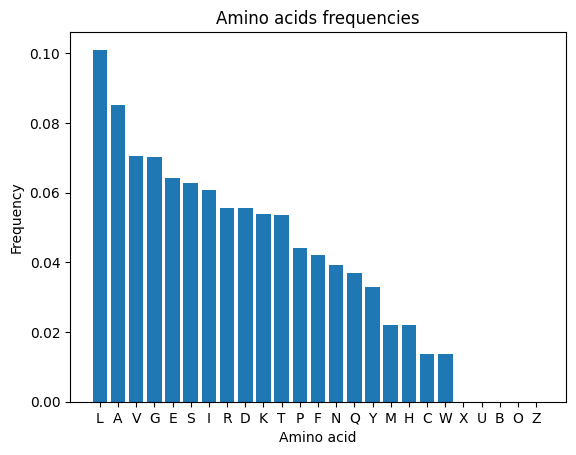

In [ ]:
counter = Counter()
df_full['sequence'].apply(lambda seq: counter.update(list(seq)))

amino_acids_counts = list(counter.items())
amino_acids_counts.sort(key=lambda x: x[1], reverse=True)

amino_acids_names, amino_acids_frequencies = [], []
for aa, count in amino_acids_counts:
    amino_acids_names.append(aa)
    amino_acids_frequencies.append(count)

amino_acids_frequencies /= np.sum(amino_acids_frequencies)

plt.bar(amino_acids_names, amino_acids_frequencies)
plt.title(f'Amino acids frequencies')
plt.xlabel('Amino acid')
plt.ylabel('Frequency')
plt.show()

We observe that certain amino acids are almost absent in the dataset (X, U, B, O, Z), and thus, we will simply exclude them from the sequences.  
Additionally, we observe that some amino acids (leucine, alanine) are significantly more prevalent than others (cysteine, tryptophan).

In [ ]:
amino_acids_to_keep = amino_acids_names[:-5]
amino_acids_to_delete = amino_acids_names[-5:]
print(f"Amino acids to keep : {amino_acids_to_keep}\nAmino acids to delete : {amino_acids_to_delete}")

Amino acids to keep : ['L', 'A', 'V', 'G', 'E', 'S', 'I', 'R', 'D', 'K', 'T', 'P', 'F', 'N', 'Q', 'Y', 'M', 'H', 'C', 'W']

Amino acids to delete : ['X', 'U', 'B', 'O', 'Z']


# **Data Processing**

## Amino acids that we keep in the sequences

Let us define the amino acids that we want to keep in the sequences.  
We also define a dictionary allowing to encode the amino acids by integers.

In [5]:
amino_acids_to_keep = list("ACDEFGHIKLMNPQRSTVWY")
dict_amino_acid_to_int = {aa: idx+1 for idx, aa in enumerate(amino_acids_to_keep)} # We start at 1 (instead of 0), because 0 will be used at the padding token

## Preprocess functions

In [6]:
def encode_amino_acid_sequence(sequence, dict_amino_acid_to_int):
    """
    Encode a protein sequence by mapping each amino acid to its corresponding integer representation.
    Amino acids not found in the dictionary are omitted from the list.

    Args:
        sequence (str): A string representing a protein sequence composed of amino acids (e.g. 'LAGCCT').
        dict_amino_acid_to_int (dict): A dictionary mapping amino acids to their integer codes.

    Returns:
        list: A list of integers where each integer represents an amino acid in the input sequence.
              Amino acids not found in the dictionary are omitted from the list.
    """

    encoded_sequence = []
    for aa in sequence:
        # If the amino acid is not found in the dicitonary, we omit it from the list
        try:
            encoded_sequence.append(dict_amino_acid_to_int[aa])
        except KeyError:
            pass
    return encoded_sequence


def pad_amino_acid_sequence(sequence, sequences_length, padding='post'):
    """
    Pad or truncate a given amino acid sequence to a specified length.

    Args:
        sequence (list): A list of integers representing an encoded amino acid sequence.
        sequences_length (int): The desired length to which the sequence should be padded or truncated.
        padding (str, optional): Specifies whether padding should be added at the beginning ('pre') or
                                 the end ('post') of the sequence. Default is 'post'.

    Returns:
        list: A list of integers representing the amino acid sequence after padding or truncation.
              If the input sequence is longer than the specified length, it is truncated.
              If it is shorter, padding is added accordingly.
    """
    padded_sequence = tf.keras.utils.pad_sequences([sequence],
                                                    maxlen=sequences_length,
                                                    padding=padding)[0]
    return padded_sequence


def preprocess_data(df, dict_family_accession_to_int, dict_family_accession_to_nb_of_train_samples, dict_amino_acid_to_int, sequences_length, padding='post', add_cls_token=False):
    """
    Preprocesses data for further deep learning process.
    It encodes every amino acid as an integer, and it adds padding to the sequences that contain less than 'sequences_length'
    amino acids.
    It also adds a 'CLS' token (encoded by an integer) at the beginning of every sequence.

    Args:
        df (pd.DataFrame): The input DataFrame containing sequence data.
        dict_family_accession_to_int (dict): A dictionary mapping family accessions to their integer codes.
        dict_amino_acid_to_int (dict): A dictionary mapping amino acids to their integer codes.
        sequences_length (int): The desired length for sequence padding or truncation.
        padding (str, optional): Specifies whether padding should be added at the beginning ('pre') or
                                 the end ('post') of the sequences. Default is 'post'.
        add_cls_token (bool, optional): Specifies whether a special token should be added at the beginning
                                        of the amino acid sequence. Default is False

    Returns:
        pd.DataFrame : The same dataframe as the one in input, but with the sequences and the labels encoded.

    """
    # Transform amino acids sequences into list of integers
    df['sequence_encoded'] = df['sequence'].apply(lambda seq: encode_amino_acid_sequence(seq, dict_amino_acid_to_int))
    if add_cls_token:
        cls_token = max([val for val in dict_amino_acid_to_int.values()]) + 1
        df['sequence_encoded'] = df['sequence_encoded'].apply(lambda seq: [cls_token]+seq)
    df['sequence_encoded'] = df['sequence_encoded'].apply(lambda seq: pad_amino_acid_sequence(seq, sequences_length, padding=padding))

    # Encode labels
    df["label"] = df["family_accession"].apply(lambda seq: dict_family_accession_to_int[seq])
    df["nb_of_train_samples"] = df["family_accession"].apply(lambda seq: dict_family_accession_to_nb_of_train_samples[seq])

    # Shuffle
    df.sample(frac=1).reset_index(drop=True)

    df = df[["sequence_encoded", "label", "nb_of_train_samples"]]

    return df

## Preprocessing parameters


In [7]:
sequences_length = 300
padding = 'post'
add_cls_token = True
num_classes = 100

## Preprocessing

In [8]:
family_counts = df_train['family_accession'].value_counts()
family_list, count_list = family_counts.index.tolist(), family_counts.values.tolist()

dict_family_accession_to_int = {}
dict_family_accession_to_nb_of_train_samples = {}
for idx, (family, count) in enumerate(zip(family_list, count_list)):
    dict_family_accession_to_int[family] = idx
    dict_family_accession_to_nb_of_train_samples[family] = count

In [9]:
df_train = preprocess_data(df_train, dict_family_accession_to_int, dict_family_accession_to_nb_of_train_samples, dict_amino_acid_to_int, sequences_length, padding=padding, add_cls_token=add_cls_token)
df_dev = preprocess_data(df_dev, dict_family_accession_to_int, dict_family_accession_to_nb_of_train_samples, dict_amino_acid_to_int, sequences_length, padding=padding, add_cls_token=add_cls_token)
df_test = preprocess_data(df_test, dict_family_accession_to_int, dict_family_accession_to_nb_of_train_samples, dict_amino_acid_to_int, sequences_length, padding=padding, add_cls_token=add_cls_token)

In [10]:
def split(df, num_classes):
    X = np.array(df[df['label'] < num_classes]['sequence_encoded'].reset_index(drop=True).to_list())
    y = df[df['label'] < num_classes]['label'].reset_index(drop=True).to_numpy()
    y_categorical = to_categorical(y, num_classes=num_classes)

    return X, y, y_categorical

X_train, y_train, y_train_categorical = split(df_train, num_classes)
X_dev, y_dev, y_dev_categorical = split(df_dev, num_classes)
X_test, y_test, y_test_categorical = split(df_test, num_classes)

## Classes weights

We will use weights during training because the dataset is very unbalanced

In [11]:
weights_train = sklearn.utils.class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(weights_train))

# Model

## Data parameters

In [12]:
data_params = {
    'input_dim': len(amino_acids_to_keep) + 2, # We add 1 for the token used for padding, and 1 for the token used for 'CLS'
    'input_length': sequences_length,
    'num_classes': num_classes
}

## Helper fuctions

In [13]:
def _test_model(class_model, data_params, embedding_params, model_params, input_shape, expected_output_shape, batch_size=4):
    """
    Test the specified model class with given parameters to ensure the expected output shape.
    The purpose is to test the model was correctly implemented.

    Args:
        class_model (class): The model class to be tested.
        data_params (dict): Parameters related to data configuration. This includes the input dimension,
                            the input length, and the number of classes
        embedding_params (dict): Parameters related to embedding layers. This might include the embedding
                                 dimension, or eventually other parameters depending on the model

        model_params (dict): Parameters related to model architecture.
        input_shape (tuple): The shape of the input data (excluding batch size).
        expected_output_shape (tuple): The expected shape of the model's output (excluding batch size).
        batch_size (int, optional): The batch size for testing. Default is 4.

    Returns:
        None

    Raises:
        AssertionError: If the model's output shape does not match the expected shape.

    """
    model = class_model(**data_params, **embedding_params, **model_params)

    input = tf.keras.Input(input_shape, batch_size=batch_size)
    print("Providing the model with input of shape:", input.shape)
    output = model(input)

    expected_output_shape_with_batch = (batch_size,) + expected_output_shape
    print(f"Expected output:", expected_output_shape_with_batch)

    assert output.shape == expected_output_shape_with_batch, f"Output should be {expected_output_shape_with_batch}, but it is {output.shape}"
    print("Test passed")

In [14]:
def compile_and_train_model(model, X, y_categorical, learning_rate, epochs, batch_size, early_stopping_patience, validation_data=None, validation_split=0, class_weight=None, verbose='auto', **kwargs):
    """
    Compile and train a deep learning model with specified parameters and settings.

    Args:
        model (tf.keras.Model): The deep learning model instance to be compiled and trained.
        X (numpy.ndarray): Input data for training.
        y_categorical (numpy.ndarray): One-hot encoded target labels.
        learning_rate (float): The learning rate for model optimization.
        epochs (int): The number of training epochs.
        batch_size (int): The batch size for training.
        early_stopping_patience (int): The number of epochs with no improvement after which training will be stopped.
        validation_data (tuple): A tuple containing validation data (X_val, y_val) for monitoring model performance
                                 during training. Default set to None.
        validation_split (float): The fraction of training data to use for validation during training. Default set to 0
        class_weight (dict): A dictionary specifying class weights for handling imbalanced datasets. Default set to None.
        verbose (int): Possibles values are 'auto', 0, 1, or 2. Default is set to 'auto'
                       Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
                      'auto' becomes 1 for most cases, but 2 when used with ParameterServerStrategy.
        **kwargs: Additional keyword arguments for model training.

    Returns:
        tf.keras.callbacks.History: A `tf.keras.callbacks.History` object containing training and validation metrics.

    """
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy']) # sparse_categorical_crossentropy

    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                   min_delta=0,
                                                   patience=early_stopping_patience,
                                                   verbose=0,
                                                   mode='auto')

    history = model.fit(X,
                        y_categorical,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=validation_data,
                        validation_split=validation_split,
                        class_weight=class_weight,
                        callbacks=[early_stopping],
                        verbose=verbose)

    return history

In [15]:
def gridsearch(class_model, X_train, y_train_categorical, gridsearch_params, metric='accuracy', verbose=1, **fixed_params):
    """
    Performs a grid search over specified parameter combinations to find the best model configuration.

    Args:
        class_model (class): The model class to be instantiated and trained.
        X_train (array-like): Training data features.
        y_train_categorical (array-like): Training data targets.
        gridsearch_params (dict): Dictionary containing parameter ranges for the grid search,
                                  structured as {'category': {'param_name': [values]}}.
                                  Categories include 'embedding_params', 'model_params', and 'training_params'.
        metric (str, optional): Performance metric to evaluate the model. Possible values are 'accuracy', 'loss'
                                Default is 'accuracy'.
        verbose (int, optional): Verbosity mode for model training.
                                 0 = silent, 1 = progress bar (default), 2 = one line per epoch.
        **fixed_params: Additional fixed parameters for the model that are not part of the grid search.

    The function iterates over all combinations of the specified parameters, training a new model instance
    for each combination and evaluating its performance using the specified metric. It keeps track of the
    best performing parameter combination.

    Returns:
        tuple: A tuple containing the best parameter combination (dict) and the corresponding best score (float).

    """
    def count_nb_steps(gridsearch_params):
        res = 1
        for key, value in gridsearch_params.items():
            for key2, value2 in value.items():
                res *= len(value2)
        return res


    assert metric in ['accuracy', 'loss'], f"Invalid metric: {metric}. Metric must be either 'accuracy' or 'loss'."
    best_score = None
    if metric == 'accuracy':
        best_score = 0
    elif metric == 'loss':
        best_score = float('inf')
    best_params = {}

    # Get params to test
    embedding_grid = list(gridsearch_params['embedding_params'].items())
    model_grid = list(gridsearch_params['model_params'].items())
    training_grid = list(gridsearch_params['training_params'].items())

    # Compute combinations
    all_params_combinations = product(*(list(product([key], value)) for key, value in (embedding_grid + model_grid + training_grid)))

    nb_steps = count_nb_steps(gridsearch_params)

    for i, params_combination in enumerate(all_params_combinations):
        print(f"Step {i+1}/{nb_steps}..")
        # The fixed params
        current_params = {**fixed_params}

        # Add the params to test to the fixed params
        for param, value in params_combination:
            current_params[param] = value

        # Train model
        model = class_model(**current_params)
        history = compile_and_train_model(model, X_train, y_train_categorical, verbose=verbose, **current_params)

        # Compute loss and compare to bets score
        score = None
        if metric == 'accuracy':
            score = np.max(history.history['val_accuracy'])
            if score > best_score:
                best_score = score
                best_params = params_combination

        if metric == 'loss':
            score = np.min(history.history['val_loss'])
            if score < best_score:
                best_score = score
                best_params = params_combination

        # Print
        print(f"Params: {params_combination}, {metric.capitalize()}: {score}\n")

    print(f"Best params: {best_params}, Best {metric}: {best_score}")

    return best_params, best_score

In [16]:
def show_history(history):
    """
    Display training and validation loss and accuracy over epochs.

    Args:
        history (tf.keras.callbacks.History): The training history object containing metrics.

    Returns:
        None

    """
    train_loss = history['loss']
    train_accuracy = history['accuracy']
    val_loss = history['val_loss']
    val_accuracy = history['val_accuracy']
    epochs = range(1, len(train_loss) + 1)

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    ax[0].plot(epochs, train_loss, label='Training loss')
    ax[0].plot(epochs, val_loss, label='Validation loss')
    ax[0].set_title('Training and Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(epochs, train_accuracy, label='Training accuracy')
    ax[1].plot(epochs, val_accuracy, label='Validation accuracy')
    ax[1].set_title('Training and Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

In [18]:
def visualize_protein_embeddings(model, X, y, nb_classes_to_analyze=30, nb_proteins_per_class=30, batch_size=32):
    """
    Visualize protein embeddings using t-SNE dimensionality reduction.

    Args:
        model (tf.keras.Model): The trained deep learning model.
        X (numpy.ndarray): Input data containing protein sequences.
        y (numpy.ndarray): Ground truth class labels corresponding to the protein sequences.
        nb_classes_to_analyze (int, optional): The number of top classes to analyze. Default is 30.
        nb_proteins_per_class (int, optional): The maximum number of proteins to analyze per class. Default is 30.
        batch_size (int, optional): The batch size for computing embeddings. Default is 32.

    Returns:
        None

    Note:
        To use this function, ensure that the provided model has a 'get_embedding_before_classification' method.
        This method should return the embeddings of protein sequences before the final classification layer.

    """
    # Compute top classes based on class frequency
    unique_classes, class_counts = np.unique(y_train, return_counts=True)
    sorted_classes = unique_classes[np.argsort(class_counts)[::-1]]
    top_classes = sorted_classes[:nb_classes_to_analyze]

    # Filter data to select top classes and limit the number of proteins per class
    filtered_indices = []
    for class_label in top_classes:
        indices_for_class = np.where(y == class_label)[0]
        if len(indices_for_class) > nb_proteins_per_class:
            indices_for_class = indices_for_class[:nb_proteins_per_class]
        filtered_indices.extend(indices_for_class)

    X = X[filtered_indices]
    y = y[filtered_indices]

    # Compute protein embeddings in batches
    embeddings_list = []

    for i in range(0, len(X), batch_size):
        batch_X = X[i:i+batch_size]
        batch_embeddings = model.get_embedding_before_classification(batch_X)
        embeddings_list.append(batch_embeddings)

    embeddings = np.concatenate(embeddings_list, axis=0)

    # Perform t-SNE dimensionality reduction for visualization
    tsne = TSNE(n_components=2)
    embeddings_tsne = tsne.fit_transform(embeddings)

    # Assign random colors to class labels
    class_colors = {}
    for label in top_classes:
        class_colors[label] = np.random.rand(3,)

    # Plot the t-SNE visualization of embeddings
    plt.figure(figsize=(8, 8))
    plt.title("Embeddings of the amino acids")
    for i, (coord_x, coord_y) in enumerate(embeddings_tsne):
        label = y[i]
        color = class_colors[label]
        plt.scatter(coord_x, coord_y, color=color)

    plt.legend()
    plt.show()

## An embedding layer

Let us create a custom Embedding layer to encode a sequence of amino acids.  
To leverage sequential information, this layer will be capable of encoding this sequential data.

Inspired by the original implementation of the Transformer by Vaswani et al. (2017), if we want to encode positional data, we have the option to use either :
- an embedding matrix based on the positions of the amino acids
- or sinusoids and cosines of different frequencies, as Vaswani et al. (2017) did  

However, they reported that the results are similar in both cases.  
They opted for sinusoids and cosines because they intended their model to handle longer sequences than the ones it was trained on.

Since our case doesn't involve longer sequences (as the sequences are truncated), I will use an embedding matrix for positional embedding.

In [19]:
class EmbeddingLayer(tf.keras.Model):
    def __init__(self, input_dim, embedding_output_dim, input_length, embedding_by_position=False, mask_zero=True, **kwargs):
        """
        Embedding layer for protein sequences. It consists of an tf.keras.Layer.Embedding based on the different amino acids,
        and eventually an embedding based on the position of every amino acid in the sequence.

        Args:
            input_dim (int): The input dimension, representing the total number of unique amino acids in the dataset (including the padding token).
            embedding_output_dim (int): The output dimension of the embedding layer, determining the size of embedding vectors for each amino acid.
            input_length (int): The input length, which isthe length of protein sequences.
            embedding_by_position (bool, optional): Whether to include position-based embeddings. Default is False.

        Returns:
            None
        """
        super().__init__()
        self.amino_acid_embedding = layers.Embedding(input_dim=input_dim, output_dim=embedding_output_dim, input_length=input_length, mask_zero=mask_zero)

        self.embedding_by_position = embedding_by_position
        if self.embedding_by_position:
            # I transform input_length into input_length+1, because I will keep the "0" token is already used for padding
            self.position_embedding = layers.Embedding(input_dim=input_length+1, output_dim=embedding_output_dim, mask_zero=mask_zero)
            self.input_length = input_length

        self.mask_zero = mask_zero

    def call(self, inputs, training=False):
        x = self.amino_acid_embedding(inputs)

        if self.embedding_by_position:
            positions = tf.range(1, self.input_length + 1)
            position_embedding = self.position_embedding(positions)
            if self.mask_zero:
                mask = tf.cast(tf.not_equal(inputs, 0), tf.float32)  # Mask for zeros in inputs
                position_embedding = position_embedding * tf.expand_dims(mask, axis=-1)  # Apply mask

            x += position_embedding
        return x

def _test():
    embedding_params = {
        'embedding_output_dim': 50,
        'embedding_by_position': True
    }
    model_params = {}

    input_shape = (data_params['input_length'],)
    expected_output_shape = (data_params['input_length'], embedding_params['embedding_output_dim'])

    _test_model(EmbeddingLayer, data_params, embedding_params, model_params, input_shape, expected_output_shape, batch_size=32)

_test()

Providing the model with input of shape: (32, 300)
Expected output: (32, 300, 50)
Test passed


## A simple feedforward neural network


To start, I will implement and train a straightforward neural network consisting of an embedding layer and two dense layers.  
The objective is to assess the performance of this simplistic model on our classification task.

If it proves effective, we will try to understand the reasons behind its success, such as by analyzing amino acid embeddings, neuron activations, and more.

### Model creation

In [20]:
class FeedforwardNeuralNetwork(tf.keras.Model):
    def __init__(self, num_classes, input_dim, embedding_output_dim, input_length, nb_dense_units=128, dropout_rate=0.2, embedding_by_position=False, mask_zero=True, **kwargs):
        """
        A simple feedforward neural network model for our classification problem.
        It is composed of two dense layers

        Args:
            num_classes (int): Number of target classes for classification.
            input_dim (int): The input dimension, representing the total number of unique amino acids in the dataset (including the padding token).
            embedding_output_dim (int): The output dimension of the embedding layer, determining the size of embedding vectors for each amino acid.
            input_length (int): The input length, typically the maximum sequence length for protein sequences.
            nb_dense_units (int, optional): The number of units in the dense hidden layer. Default is 128.
            dropout_rate (float, optional): Dropout rate for regularization. Default is 0.2.
            embedding_by_position (bool, optional): Whether to include position-based embeddings. Default is False.

        Returns:
            None

        Methods:
            call(inputs, training=False): The forward pass of the model.
            get_embedding_before_classification(inputs, training=False): Retrieves the representation of the input just before the classification layer.

        The `call` method defines the forward pass of the model and returns the output of the softmax layer.
        The `get_embedding_before_classification` method is useful for extracting the learned representations before the final classification is applied,
        which can be useful for analysis (or transfer learning eventually, but not for this notebook).

        """
        super().__init__()
        self.embedding_layer = EmbeddingLayer(input_dim=input_dim,
                                              embedding_output_dim=embedding_output_dim,
                                              input_length=input_length,
                                              embedding_by_position=embedding_by_position,
                                              mask_zero=mask_zero)

        self.flatten = layers.Flatten()
        self.dense = layers.Dense(nb_dense_units, activation='relu')
        self.dropout = layers.Dropout(dropout_rate)
        self.dense_softmax = layers.Dense(num_classes, activation='softmax')

        self.activations = {} # We will use this to analyze the activations of the model

    def call(self, inputs, training=False):
        x = self.embedding_layer(inputs)
        x = self.flatten(x)
        self.activations['embedding'] = x

        x = self.dense(x)
        self.activations['dense'] = x

        x = self.dropout(x, training=training)

        x = self.dense_softmax(x)
        self.activations['softmax'] = x

        return x

    def get_embedding_before_classification(self, inputs, training=False):
        """
        This method calls all the layers of the neural network, excepted the last one (the one that performs the softmax activation function)
        This provides embeddings for the inputs
        """
        x = self.embedding_layer(inputs)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.dropout(x, training=training)

        return x


def _test():
    embedding_params = {
        'embedding_output_dim': 50,
        'embedding_by_position': True
    }
    model_params = {
        'nb_dense_units': 256,
        'dropout_rate': 0.2
    }

    input_shape = (data_params['input_length'],)
    expected_output_shape = (data_params['num_classes'],)

    _test_model(FeedforwardNeuralNetwork, data_params, embedding_params, model_params, input_shape, expected_output_shape, batch_size=32)


_test()

Providing the model with input of shape: (32, 300)
Expected output: (32, 100)
Test passed


### GridSearch

In [ ]:
embedding_params = {
    'embedding_by_position': False,
    'mask_zero': True,
}
model_params = {
    'dropout_rate': 0.2,
    'nb_dense_units': 128
}
training_params = {
    'learning_rate': 1e-3,
    'batch_size': 64,
    'epochs': 30,
    'early_stopping_patience': 4,
    'validation_data': (X_dev, y_dev_categorical),
    'class_weight': class_weight_dict
}

gridsearch_params = {
    'embedding_params': {
        'embedding_output_dim': [10, 20],
        'embedding_by_position': [True, False]
    },
    'model_params': {
        'nb_dense_units': [128, 256],
        'dropout_rate': [0.1, 0.2]
    },
    'training_params': {
    }
}

I will not conduct a grid search on the entire dataset due to computational time constraints. This is not optimal, but it will still allows to find a good set of hyperparameters.  
We will eventually conduct a more comprehensive search for the best hyperparameters once we identify the architecture that yields the best results.

If one wants to conduct the grid search again, uncomment the following code.

In [ ]:
"""
best_params, best_score = gridsearch(FeedforwardNeuralNetwork,
                                     X_train[:40000],
                                     y_train_categorical[:40000],
                                     gridsearch_params,
                                     metric='loss',
                                     verbose='auto',
                                     **data_params,
                                     **embedding_params,
                                     **model_params,
                                     **training_params)
"""

In [ ]:
# print(f"Best params : {best_params}\nBest score : {best_score}")

Best params : (('embedding_output_dim', 20), ('embedding_by_position', False), ('nb_dense_units', 256), ('dropout_rate', 0.2))



Best score : 0.021221822127699852


### Best hyperparameters

In [21]:
embedding_params = {
    'embedding_output_dim': 20,
    'embedding_by_position': False,
    'mask_zero': True,
}
model_params = {
    'nb_dense_units': 256,
    'dropout_rate': 0.2
}
training_params = {
    'learning_rate': 1e-3,
    'batch_size': 64,
    'epochs': 50,
    'early_stopping_patience': 4,
    'validation_data': (X_dev, y_dev_categorical),
    'class_weight': class_weight_dict
}

### Train

In [22]:
model = FeedforwardNeuralNetwork(**data_params, **embedding_params, **model_params)
history = compile_and_train_model(model, X_train, y_train_categorical, **training_params)

Epoch 1/50
1453/1453 [==============================] - 8s 4ms/step - loss: 0.3296 - accuracy: 0.9276 - val_loss: 0.0259 - val_accuracy: 0.9946
Epoch 2/50
1453/1453 [==============================] - 5s 4ms/step - loss: 0.0084 - accuracy: 0.9983 - val_loss: 0.0213 - val_accuracy: 0.9949
Epoch 3/50
1453/1453 [==============================] - 5s 4ms/step - loss: 0.0025 - accuracy: 0.9995 - val_loss: 0.0210 - val_accuracy: 0.9951
Epoch 4/50
1453/1453 [==============================] - 5s 4ms/step - loss: 0.0037 - accuracy: 0.9989 - val_loss: 0.0330 - val_accuracy: 0.9928
Epoch 5/50
1453/1453 [==============================] - 5s 4ms/step - loss: 0.0039 - accuracy: 0.9989 - val_loss: 0.0333 - val_accuracy: 0.9941
Epoch 6/50
1453/1453 [==============================] - 5s 4ms/step - loss: 0.0039 - accuracy: 0.9987 - val_loss: 0.0367 - val_accuracy: 0.9936
Epoch 7/50
1453/1453 [==============================] - 5s 4ms/step - loss: 0.0034 - accuracy: 0.9989 - val_loss: 0.0423 - val_accuracy:

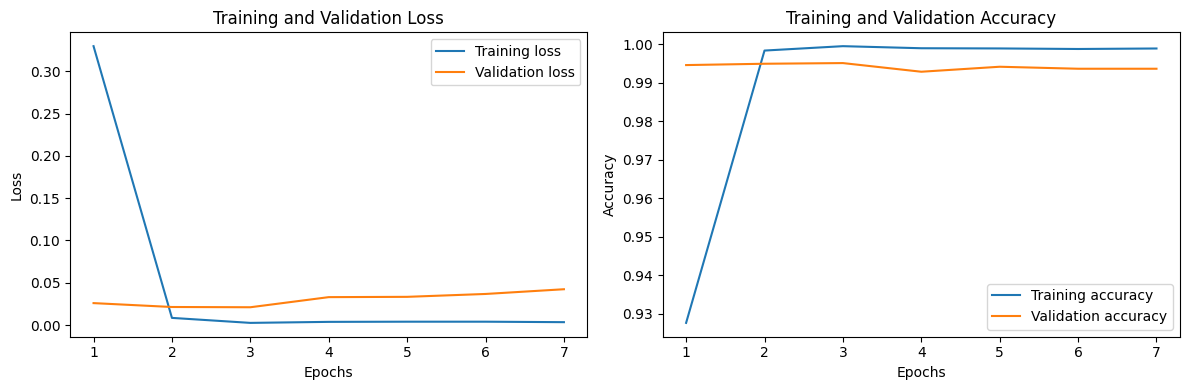

In [23]:
show_history(history.history)

### Tests

In [24]:
loss, accuracy = model.evaluate(X_test, y_test_categorical)
print("Accuracy on test : ", accuracy)

362/362 [==============================] - 1s 3ms/step - loss: 0.0305 - accuracy: 0.9936
Accuracy on test :  0.993601381778717


The model gives pretty good results, considering the simplicity of the model.  
Let's try to analyze how it achieved this.

### Analysis of the model

#### The amino acids embeddings

First, we will visualize the amino acid embeddings computed by the embedding layer.

In [25]:
# Encode amino acids
amino_acids_encoded = encode_amino_acid_sequence(amino_acids_to_keep, dict_amino_acid_to_int)
amino_acids_encoded_padded = pad_amino_acid_sequence(amino_acids_encoded, sequences_length=sequences_length, padding=padding)

# Compute embeddings
output = model.embedding_layer(np.array([amino_acids_encoded_padded]))
embeddings = output[0, 0:len(amino_acids_to_keep), :]

##### Visualization with Principal Component Analysis (PCA)

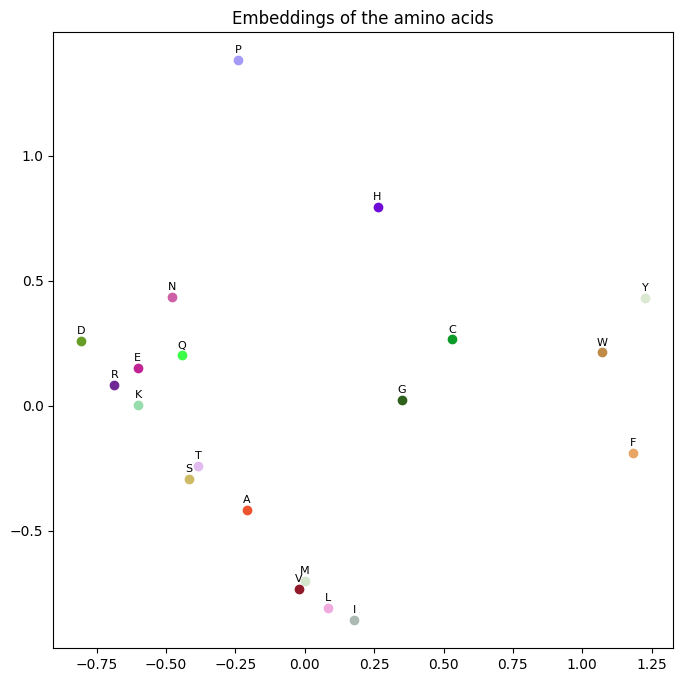

In [26]:
# Compute PCA
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

# Show
plt.figure(figsize=(8, 8))
plt.title("Embeddings of the amino acids")
for i, (x, y) in enumerate(embeddings_pca):
    plt.scatter(x, y, color=np.random.rand(3,))
    plt.annotate(amino_acids_to_keep[i], (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)

plt.show()

We notice that amino acids that share some properties are close to each other. For instance :
- Leucine and Isoleucine are close to each other
- Aromatic amino acids (Tryptophan, Tyrosin, Phenylalanin) are close to each other
- Proline is quite distant, possibly due to its unique structure.
- In some attempts (but not the above one), Cysteine was also notably distant, possibly because of its specific role (it is the only amino acid capable of forming sulfate bonds).

It seems that the model captured some properties of amino acids, so it seems that the embedding is working well.  
We will keep this embedding layer for the next steps.

##### Similarity between amino acids

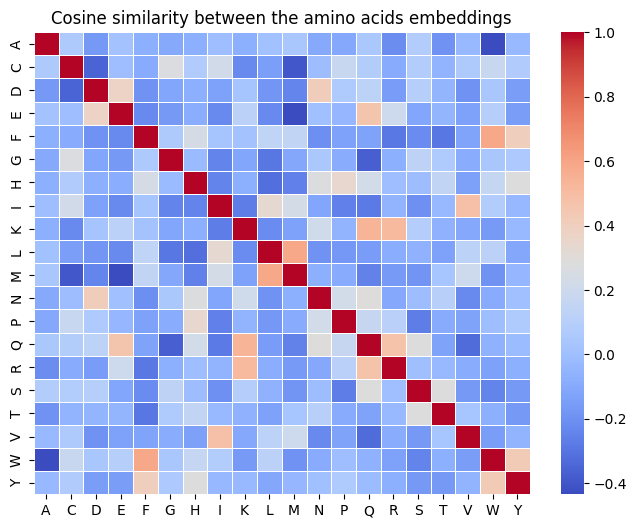

In [27]:
# Compute similarities
similarities = sklearn.metrics.pairwise.cosine_similarity(embeddings)

# Show heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(similarities, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5,
            xticklabels=amino_acids_to_keep, yticklabels=amino_acids_to_keep)  # Utilisation des labels pour les axes
plt.title('Cosine similarity between the amino acids embeddings')
plt.show()

This confirms what the previous figure shows.

#### The protein embeddings

We will also visualize the last layer (before the softmax is applied) to see how well the different sequences were separated.

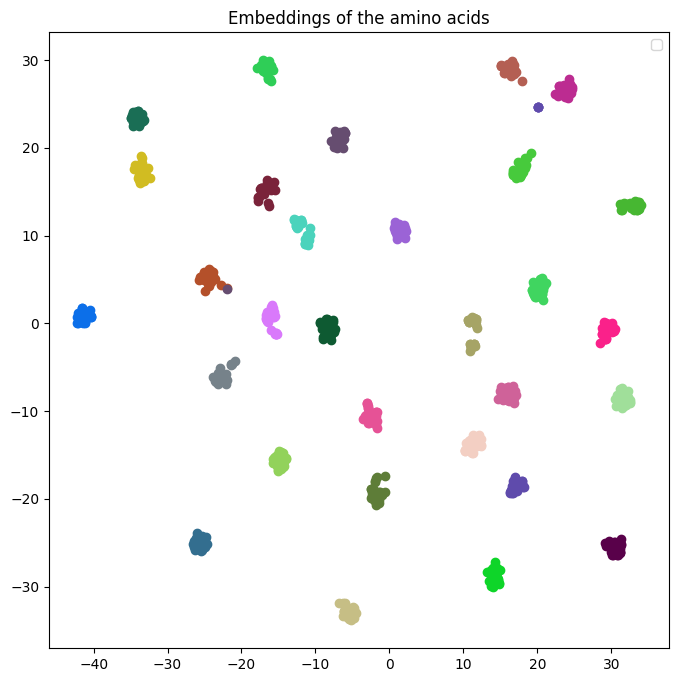

In [ ]:
visualize_protein_embeddings(model, X_train, y_train, nb_classes_to_analyze=30, nb_proteins_per_class=30)

Although it is not perfect, the model has been able to make a good separation between all the protein domains.  
We might be able to do better with other architectures.  
The quality of the protein embeddings may be important in the future, for instance to use these embeddings to perform a nearest neighbors classification (as they did in _Bileschi et al. (2019)_)

#### Visualization of the neurons activation

In [ ]:
# Parameters
nb_classes_to_compare = 5
nb_proteins_to_keep_per_class = 20

# Compute the labels to compare
unique_labels = np.unique(y_train)
labels_to_compare = unique_labels[:nb_classes_to_compare]

In [ ]:
# Initialize list that will contain the activations
all_X = []
all_activations = {'embedding': [], 'dense': [], 'softmax': []}

# Get all the activation values
for label in labels_to_compare:
    X = X_train[y_train == label][:nb_proteins_to_keep_per_class]
    all_X.append(X)
    _ = model(X)

    for key, value in model.activations.items():
        all_activations[key].append(value[:, :200]) # We only keep the 150 first values of every layer, in order to be able to see something

# Convert to numpy
all_X = np.concatenate(all_X, axis=0)
for key, value in all_activations.items():
    all_activations[key] = np.concatenate(value, axis=0)

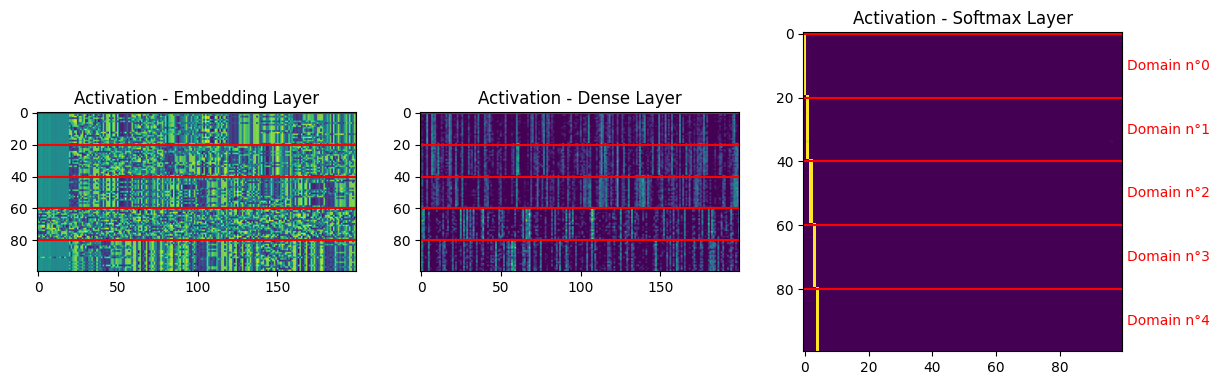

In [ ]:
# Show
plt.figure(figsize=(14, 14))

cmap = 'viridis'
for subplot, layer in zip([131, 132, 133], ['embedding', 'dense', 'softmax']):
    plt.subplot(subplot)
    plt.imshow(all_activations[layer], cmap=cmap)
    plt.title(f'Activation - {layer.capitalize()} Layer')
    for i in range(nb_classes_to_compare):
        plt.axhline(y=i*nb_proteins_to_keep_per_class, color='red')

        if subplot == 133:
            plt.text(x=all_activations[layer].shape[-1] + 1,
                     y=(i + 1/2)*nb_proteins_to_keep_per_class,
                     s=f'Domain n°{i}',
                     color='red',
                     va='center')

plt.show()

For multiple sequences from a same family, we can see that there are some common areas in the embedding layer.  
It shows that the model was able to find some patterns in the amino acid sequences.  
We can also see that the neurons that activate in the dense layer are (almost) always the same for a same family.  

It shows that some other architectures, like CNNs, may be pertinent. We will try to implement one to compare the results.

## Convolutional Neural Network

### Model creation

The following model is a Convolutional Neural Network, followed by two dense layers.  
A particularity of this CNN is that there are filters with different sizes.  
This is inspired by _Bileschi et al. (2019)_ (see in references).

Although my CNN implementation allows for multiple convolution layers, in the experiments I conducted, the best results were achieved with a single convolutional layer.

In [92]:
class CNN(tf.keras.Model):
    def __init__(self, num_classes, input_dim, embedding_output_dim, input_length, num_conv_layers=1, nb_filters_per_kernel_size=16, kernel_sizes=[9], nb_dense_units=256, dropout_rate=0.2, embedding_by_position=False, mask_zero=True, **kwargs):
        """
        This model applies a convolutional neural network to sequences for classification purposes.
        It includes an embedding layer, multiple convolutional layers, a dense layer, and a softmax output layer.
        The model can handle varying kernel sizes for convolutional layers.

        Args:
            num_classes (int): Number of target classes for classification.
            input_dim (int): The input dimension, representing the total number of unique amino acids in the dataset (including the padding token).
            embedding_output_dim (int): The output dimension of the embedding layer, determining the size of embedding vectors for each amino acid.
            input_length (int): The input length, typically the maximum sequence length for protein sequences.
            nb_filters_per_kernel_size (int, optional): The number of filters per kernel size in the convolutional layers. Default set to 16.
            kernel_sizes (list, optional): A list of kernel sizes for the convolution filters. Default set to [9].
            nb_dense_units (int, optional): The number of units in the dense layer following the convolutional layers. Default set to 256.
            dropout_rate (float, optional): The dropout rate applied after the dense layer for regularization. Default set to 0.2.
            embedding_by_position (bool, optional): A flag to indicate whether positional embeddings should be used. Default set to False.

        Methods:
            call(inputs, training=False): The forward pass of the model.
            get_embedding_before_classification(inputs, training=False): Retrieves the representation of the input just before the classification layer.

        The `call` method defines the forward pass of the model and returns the output of the softmax layer.
        The `get_embedding_before_classification` method is useful for extracting the learned representations before the final classification is applied,
        which can be useful for analysis (or transfer learning eventually, but not for this notebook).
        """
        super().__init__()
        self.embedding_layer = EmbeddingLayer(input_dim=input_dim,
                                              embedding_output_dim=embedding_output_dim,
                                              input_length=input_length,
                                              embedding_by_position=embedding_by_position,
                                              mask_zero=mask_zero)
        self.flatten = layers.Flatten()

        self.conv_layers = [self.generate_conv_layer(2**i*nb_filters_per_kernel_size, kernel_sizes) for i in range(num_conv_layers)]
        self.dense = layers.Dense(nb_dense_units, activation='relu')
        self.dropout = layers.Dropout(dropout_rate)
        self.dense_softmax = layers.Dense(num_classes, activation='softmax')
    
    def generate_conv_layer(self, nb_filters_per_kernel_size, kernel_sizes):
        return [layers.Conv1D(filters=nb_filters_per_kernel_size, kernel_size=kernel_size, activation='relu', padding='same') 
                      for kernel_size in kernel_sizes]
        
    def call(self, inputs, training=False):
        x = self.embedding_layer(inputs)
        for conv_layer in self.conv_layers:
            x = tf.concat([conv(x) for conv in conv_layer], axis=-1)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.dropout(x, training)
        x = self.dense_softmax(x)
        return x

    def get_embedding_before_classification(self, inputs, training=False):
        x = self.embedding_layer(inputs)
        x = tf.concat([conv(x) for conv in self.convs], axis=-1)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.dropout(x, training)
        return x

def _test():
    embedding_params = {
        'embedding_output_dim': 20,
        'embedding_by_position': True
    }
    model_params = {
        'num_conv_layers': 2,
        'nb_filters_per_kernel_size': 16,
        'kernel_sizes': [3, 7],
        'nb_dense_units': 256,
        'dropout_rate': 0.2
    }

    input_shape = (data_params['input_length'],)
    expected_output_shape = (data_params['num_classes'],)

    _test_model(CNN, data_params, embedding_params, model_params, input_shape, expected_output_shape, batch_size=32)

_test()

Providing the model with input of shape: (32, 300)
Expected output: (32, 17929)
Test passed


### Gridsearch

In [ ]:
embedding_params = {
    'embedding_output_dim': 20,
    'embedding_by_position': False,
    'mask_zero': True,
}

model_params = {
    'nb_dense_units': 256,
    'dropout_rate': 0.3
}
training_params = {
    'learning_rate': 1e-3,
    'batch_size': 64,
    'epochs': 50,
    'early_stopping_patience': 3,
    'validation_data': (X_dev, y_dev_categorical),
    'class_weight': class_weight_dict
}

gridsearch_params = {
    'embedding_params': {
        'embedding_output_dim': [10, 20],
        'embedding_by_position': [True, False]
    },
    'model_params': {
        'kernel_sizes': [[7, 13, 19, 25],
                         [7, 11, 15, 17, 19, 21, 23, 25]
        ],
        'nb_filters_per_kernel_size': [16, 32]
    },
    'training_params': {
    }
}

If one wants to conduct the grid search again, uncomment the following code.

In [ ]:
"""
best_params, best_score = gridsearch(CNN,
                                     X_train[:40000],
                                     y_train_categorical[:40000],
                                     gridsearch_params,
                                     metric='loss',
                                     verbose=0,
                                     **data_params,
                                     **embedding_params,
                                     **model_params,
                                     **training_params)
"""

Step 1/16..



Params: (('embedding_output_dim', 10), ('embedding_by_position', True), ('kernel_sizes', [7, 13, 19, 25]), ('nb_filters_per_kernel_size', 16)), Loss: 0.0242785532027483







Step 2/16..



Params: (('embedding_output_dim', 10), ('embedding_by_position', True), ('kernel_sizes', [7, 13, 19, 25]), ('nb_filters_per_kernel_size', 32)), Loss: 0.025506209582090378







Step 3/16..



Params: (('embedding_output_dim', 10), ('embedding_by_position', True), ('kernel_sizes', [7, 11, 15, 17, 19, 21, 23, 25]), ('nb_filters_per_kernel_size', 16)), Loss: 0.02443099580705166







Step 4/16..



Params: (('embedding_output_dim', 10), ('embedding_by_position', True), ('kernel_sizes', [7, 11, 15, 17, 19, 21, 23, 25]), ('nb_filters_per_kernel_size', 32)), Loss: 0.019009696319699287







Step 5/16..



Params: (('embedding_output_dim', 10), ('embedding_by_position', False), ('kernel_sizes', [7, 13, 19, 25]), ('nb_filters_per_kernel_size', 16)), Loss: 0.030151689425110817







Step 

In [ ]:
# print(f"Best params : {best_params}\nBest score : {best_score}")

Best params : (('embedding_output_dim', 20), ('embedding_by_position', False), ('kernel_sizes', [7, 11, 15, 17, 19, 21, 23, 25]), ('nb_filters_per_kernel_size', 32))



Best score : 0.012655646540224552


### Best hyperparameters

In [29]:
embedding_params = {
    'embedding_output_dim': 20,
    'embedding_by_position': False,
    'mask_zero': True,
}
model_params = {
    'nb_filters_per_kernel_size': 32,
    'kernel_sizes': [7, 11, 15, 17, 19, 21, 23, 25],
    'nb_dense_units': 256,
    'dropout_rate': 0.3
}
training_params = {
    'learning_rate': 1e-3,
    'batch_size': 64,
    'epochs': 50,
    'early_stopping_patience': 4,
    'validation_data': (X_dev, y_dev_categorical),
    'class_weight': class_weight_dict
}

### Train

In [30]:
model = CNN(**data_params, **embedding_params, **model_params)
history = compile_and_train_model(model, X_train, y_train_categorical, **training_params)

Epoch 1/50
1453/1453 [==============================] - 22s 11ms/step - loss: 0.2334 - accuracy: 0.9444 - val_loss: 0.0121 - val_accuracy: 0.9965
Epoch 2/50
1453/1453 [==============================] - 16s 11ms/step - loss: 0.0156 - accuracy: 0.9961 - val_loss: 0.0120 - val_accuracy: 0.9969
Epoch 3/50
1453/1453 [==============================] - 16s 11ms/step - loss: 0.0090 - accuracy: 0.9973 - val_loss: 0.0105 - val_accuracy: 0.9973
Epoch 4/50
1453/1453 [==============================] - 16s 11ms/step - loss: 0.0063 - accuracy: 0.9980 - val_loss: 0.0082 - val_accuracy: 0.9977
Epoch 5/50
1453/1453 [==============================] - 16s 11ms/step - loss: 0.0050 - accuracy: 0.9987 - val_loss: 0.0074 - val_accuracy: 0.9979
Epoch 6/50
1453/1453 [==============================] - 16s 11ms/step - loss: 0.0044 - accuracy: 0.9988 - val_loss: 0.0094 - val_accuracy: 0.9978
Epoch 7/50
1453/1453 [==============================] - 16s 11ms/step - loss: 0.0027 - accuracy: 0.9992 - val_loss: 0.0105 -

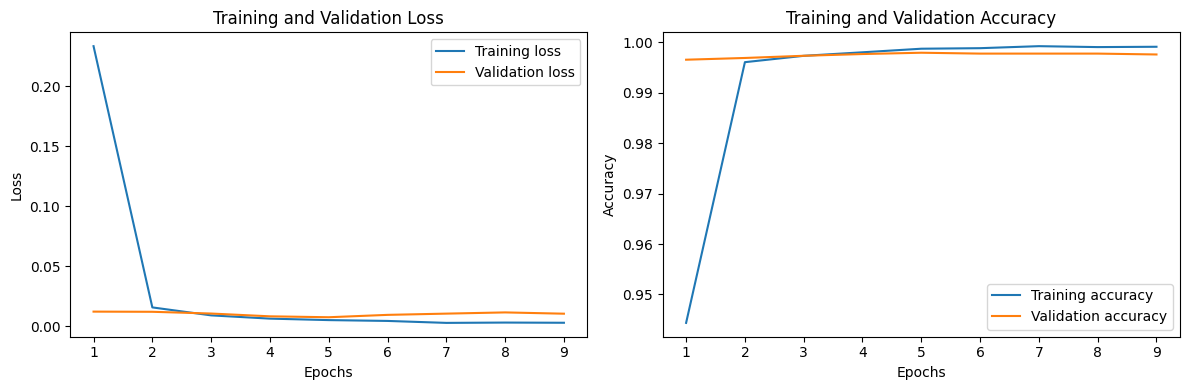

In [31]:
show_history(history.history)

### Tests

In [32]:
loss, accuracy = model.evaluate(X_test, y_test_categorical)
print("Accuracy on test : ", accuracy)

362/362 [==============================] - 1s 4ms/step - loss: 0.0087 - accuracy: 0.9983
Accuracy on test :  0.9982706308364868


This CNN gives better results than the previous model. Let us analyze the quality of the embeddings.

### Analysis of the model

#### Protein embeddings

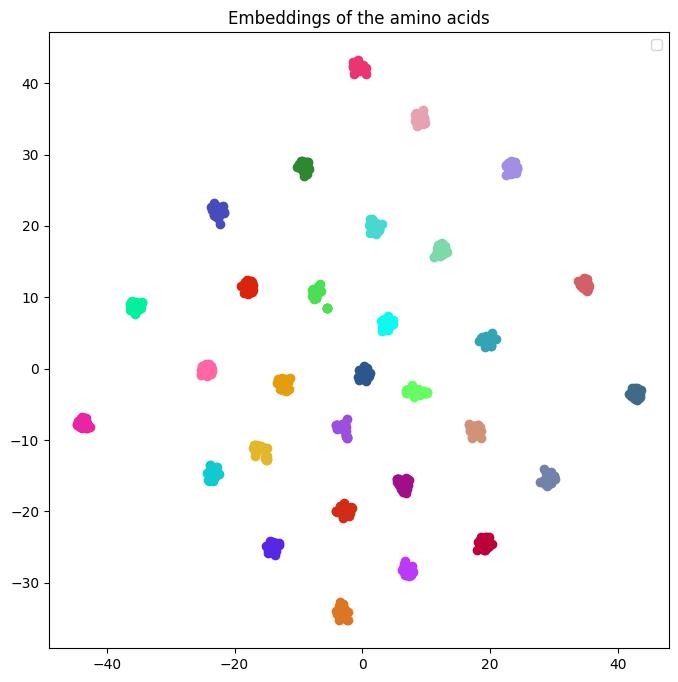

In [33]:
visualize_protein_embeddings(model, X_train, y_train, nb_classes_to_analyze=30, nb_proteins_per_class=30)

The model appears to generate highly effective embeddings, as sequences within the same family exhibit close proximity.

## Residual neural network

I will also try to add residual connections to the previous model.  
This is motivated by the fact that residual neural networks often yield superior results compared to standard convolutional networks. Aditionally, this approach aligns with the methodology used in _Bileschi et al. (2019)_.

### Model creation

In [35]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, layer_index, num_first_dilated_layer=2, dilation_rate=2, bottleneck_factor=0.5, nb_filters_per_kernel_size=100, kernel_sizes=[9, 17], dropout_rate=0.2, **kwargs):
        """
        This layer implements a single residual block, which is a fundamental building block in Residual Networks.
        It consists of two convolution layers, which are eventually dilated, and a residual connection.
        The first convolutional layer is applied in parallel for different kernel sizes and the results are concatenated.
        This is followed by a bottleneck layer (a convolutional layer with a kernel size of 1) to reduce dimensionality.
        Dropout and ReLU activation are used after each convolutional layer.
        The output of the block is the sum of its input and its processed signal (residual connection), which helps to
        mitigate the vanishing gradient problem in deep networks.

        Args:
            layer_index (int): The index of the layer in the overall network architecture, used for calculating the dilation rate.
            num_first_dilated_layer (int): The layer index at which dilation begins. Default is 2.
            dilation_rate (int): The base dilation rate that is exponentially increased with the layer index. Default is 2.
            bottleneck_factor (float): A scaling factor for reducing the dimensionality in the bottleneck. Default is 0.5.
            nb_filters_per_kernel_size (int): The number of filters for each kernel size in the convolutional layers. Default is 100.
            kernel_sizes (list of int): The sizes of the kernels used in the convolutional layers. Default is [9, 17].
            dropout_rate (float): Dropout rate used for regularization in the block. Default is 0.2.


        The `call` method defines the forward pass through the residual block.

        Example:
            # Example usage in a larger model
            residual_block = ResidualBlock(...)
            output = residual_block(input_tensor)

        """
        super().__init__()
        self.layer_index = layer_index

        # Calculate dilation rate for this block
        shifted_layer_index = (layer_index + 1) - num_first_dilated_layer + 1
        self.dilation_rate = max(1, dilation_rate ** shifted_layer_index)

        self.num_bottleneck_units = int(math.floor(bottleneck_factor * nb_filters_per_kernel_size))

        # First Convolution Layer in the Residual Block
        self.list_conv1 = [tf.keras.layers.Conv1D(
            filters=self.num_bottleneck_units,
            kernel_size=kernel_size,
            padding='same',
            dilation_rate=self.dilation_rate
        ) for kernel_size in kernel_sizes]

        # Second Convolution Layer in the Residual Block
        self.conv2 = tf.keras.layers.Conv1D(
            filters=nb_filters_per_kernel_size*len(kernel_sizes),
            kernel_size=1,  # kernel size of 1 for the linear transformation
            padding='same'
        )

        self.relu = layers.ReLU()
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, inputs, training):
        x = inputs
        # x = tf.keras.layers.BatchNormalization()(x)
        x = self.relu(x)
        x = tf.concat([conv(x) for conv in self.list_conv1], axis=-1)
        x = self.dropout(x, training=training)
        # x = tf.keras.layers.BatchNormalization()(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.dropout(x, training=training)
        x += inputs

        return x

def _test():
    embedding_params = {}
    model_params = {
        'layer_index': 0,
        'num_first_dilated_layer': 2,
        'dilation_rate': 2,
        'bottleneck_factor': 0.5,
        'nb_filters_per_kernel_size': 16,
        'kernel_sizes': [3, 9],
        'dropout_rate': 0.2
    }

    latent_dim = model_params['nb_filters_per_kernel_size'] * len(model_params['kernel_sizes'])

    input_shape = (data_params['input_length'], latent_dim)
    expected_output_shape = (data_params['input_length'], latent_dim)

    _test_model(ResidualBlock, data_params, embedding_params, model_params, input_shape, expected_output_shape, batch_size=32)


_test()

Providing the model with input of shape: (32, 300, 32)
Expected output: (32, 300, 32)
Test passed


For residual networks, some researchers use max pooling before feeding the input to the last dense layers.  
However, I found that a Flatten layer leads to better results, this is why I used a Flatten layer instead of a max pooling (I could not perform a gridsearch on this parameter too, it already requires too much computation power)

In [36]:
class ProteinResNet(tf.keras.Model):
    def __init__(self, num_classes, input_dim, embedding_output_dim, input_length, num_layers=5, num_first_dilated_layer=2, dilation_rate=2, bottleneck_factor=0.5, nb_filters_per_kernel_size=100, kernel_sizes=[9, 17], nb_dense_units=256, dropout_rate=0.2, embedding_by_position=False, mask_zero=True, **kwargs):
        """
        A specialized implementation of the Residual Network (ResNet) for protein sequence classification.
        The model begins with an embedding layer, followed by a series of convolutional layers and a series of residual blocks.
        The output of the residual blocks is then flattened and passed through a dense layer with softmax activation for classification.

        Args:
            num_classes (int): Number of target classes for classification.
            input_dim (int): The input dimension, representing the total number of unique amino acids.
            embedding_output_dim (int): The output dimension of the embedding layer.
            input_length (int): The input length, typically the maximum sequence length for protein sequences.
            num_layers (int, optional): The number of residual blocks in the network. Default is 5.
            num_first_dilated_layer (int, optional): The layer index at which dilation begins in the residual blocks.
                                                     Default is 2.
            dilation_rate (int, optional): The base dilation rate for the residual blocks. Default is 2.
            bottleneck_factor (float, optional): A factor to control the bottleneck size in the residual blocks.
                                                 Default is 0.5.
            nb_filters_per_kernel_size (int, optional): The number of filters per kernel size in the convolutional layers.
                                                        Default is 100.
            kernel_sizes (list of int, optional): The sizes of the kernels used in the convolutional layers.
                                                  Default is [9, 17].
            nb_dense_units (int, optional): The number of units in the final dense layer. Default is 256.
            dropout_rate (float, optional): Dropout rate for regularization. Default is 0.2.
            embedding_by_position (bool, optional): Whether to include position-based embeddings. Default is False.

        Methods:
            call(inputs, training=False): The forward pass of the model.
            get_embedding_before_classification(inputs, training=False): Retrieves the representation of the input just before the classification layer.

        The `call` method defines the forward pass of the model and returns the output of the softmax layer.
        The `get_embedding_before_classification` method is useful for extracting the learned representations before the final classification is applied,
        which can be useful for analysis (or transfer learning eventually, but not for this notebook).

        """
        super().__init__()
        self.embedding_layer = EmbeddingLayer(input_dim=input_dim,
                                              embedding_output_dim=embedding_output_dim,
                                              input_length=input_length,
                                              embedding_by_position=embedding_by_position,
                                              mask_zero=mask_zero)

        self.convs = [tf.keras.layers.Conv1D(
            filters=nb_filters_per_kernel_size,
            kernel_size=kernel_size,
            padding='same'
        ) for kernel_size in kernel_sizes]

        self.residual_blocks = [ResidualBlock(layer_index=i,
                                              num_first_dilated_layer=num_first_dilated_layer,
                                              dilation_rate=dilation_rate,
                                              bottleneck_factor=bottleneck_factor,
                                              nb_filters_per_kernel_size=nb_filters_per_kernel_size,
                                              kernel_sizes=kernel_sizes,
                                              dropout_rate=dropout_rate) for i in range(num_layers)]

        self.dense = layers.Dense(nb_dense_units, activation='relu')
        self.dense_softmax = layers.Dense(num_classes, activation='softmax')
        self.dropout = layers.Dropout(dropout_rate)

    def call(self, inputs, training=False):
        x = self.embedding_layer(inputs)
        x = self.dropout(x, training=training)

        x = tf.concat([conv(x) for conv in self.convs], axis=-1)
        x = self.dropout(x, training=training)

        for residual_block in self.residual_blocks:
            x = residual_block(x, training)

        x = layers.Flatten()(x) # Better than max pooling
        x = self.dense(x)
        x = self.dropout(x, training=training)

        x = self.dense_softmax(x)

        return x

    def get_embedding_before_classification(self, inputs, training=False):
        x = self.embedding_layer(inputs)
        x = self.dropout(x, training=training)

        x = tf.concat([conv(x) for conv in self.convs], axis=-1)
        x = self.dropout(x, training=training)

        for residual_block in self.residual_blocks:
            x = residual_block(x, training)

        x = layers.Flatten()(x) # Works better than max pooling
        x = self.dense(x)
        x = self.dropout(x, training=training)

        return x

def _test():
    embedding_params = {
        'embedding_output_dim': 20,
        'embedding_by_position': False
    }
    model_params = {
        'num_layers': 5,
        'num_first_dilated_layer': 2,
        'dilation_rate': 2,
        'bottleneck_factor': 0.5,
        'nb_filters_per_kernel_size': 16,
        'kernel_sizes': [7, 11, 15, 17, 19, 21, 23, 25],
        'nb_dense_units': 256,
        'dropout_rate': 0.4
    }

    input_shape = (data_params['input_length'],)
    expected_output_shape = (data_params['num_classes'],)

    _test_model(ProteinResNet, data_params, embedding_params, model_params, input_shape, expected_output_shape, batch_size=8)

_test()

Providing the model with input of shape: (8, 300)
Expected output: (8, 100)
Test passed


### Gridsearch

In [34]:
embedding_params = {
    'embedding_output_dim': 20,
    'embedding_by_position': False,
    'mask_zero': True,
}
model_params = {
    'num_layers': 2,
    'num_first_dilated_layer': 2,
    'dilation_rate': 2,
    'bottleneck_factor': 0.5,
    'nb_filters_per_kernel_size': 16,
    'kernel_sizes': [7, 11, 15, 17, 19, 21, 23, 25],
    'nb_dense_units': 128,
    'dropout_rate': 0.2
}
training_params = {
    'learning_rate': 1e-3,
    'batch_size': 64,
    'epochs': 30,
    'early_stopping_patience': 2,
    'validation_data': (X_dev, y_dev_categorical),
    'class_weight': class_weight_dict
}

gridsearch_params = {
    'embedding_params': {
    },
    'model_params': {
        'num_layers': [1, 2],
        'nb_filters_per_kernel_size': [16, 32],
        'nb_dense_units': [128, 256]
    },
    'training_params': {
    }
}

In [ ]:
"""
best_params, best_score = gridsearch(ProteinResNet,
                                     X_train[:40000],
                                     y_train_categorical[:40000],
                                     gridsearch_params,
                                     metric='loss',
                                     verbose='auto',
                                     **data_params,
                                     **embedding_params,
                                     **model_params,
                                     **training_params)
"""

In [ ]:
# print(f"Best params : {best_params}\nBest score : {best_score}")

Best params : (('num_layers', 2), ('nb_filters_per_kernel_size', 16), ('nb_dense_units', 128))



Best score : 0.029701653867959976


### Best hyperparameters

In [38]:
embedding_params = {
    'embedding_output_dim': 20,
    'embedding_by_position': False,
    'mask_zero': True,
}
model_params = {
    'num_layers': 2,
    'num_first_dilated_layer': 2,
    'dilation_rate': 2,
    'bottleneck_factor': 0.5,
    'nb_filters_per_kernel_size': 16,
    'kernel_sizes': [7, 11, 15, 17, 19, 21, 23, 25],
    'nb_dense_units': 128,
    'dropout_rate': 0.2
}
training_params = {
    'learning_rate': 1e-3,
    'batch_size': 64,
    'epochs': 30,
    'early_stopping_patience': 1,
    'validation_data': (X_dev, y_dev_categorical),
    'class_weight': class_weight_dict
}

### Train

In [39]:
model = ProteinResNet(**data_params, **embedding_params, **model_params)
history = compile_and_train_model(model, X_train, y_train_categorical, **training_params)

Epoch 1/30
1453/1453 [==============================] - 67s 38ms/step - loss: 0.2447 - accuracy: 0.9393 - val_loss: 0.0236 - val_accuracy: 0.9943
Epoch 2/30
1453/1453 [==============================] - 52s 36ms/step - loss: 0.0391 - accuracy: 0.9892 - val_loss: 0.0214 - val_accuracy: 0.9944
Epoch 3/30
1453/1453 [==============================] - 53s 36ms/step - loss: 0.0353 - accuracy: 0.9908 - val_loss: 0.0315 - val_accuracy: 0.9947


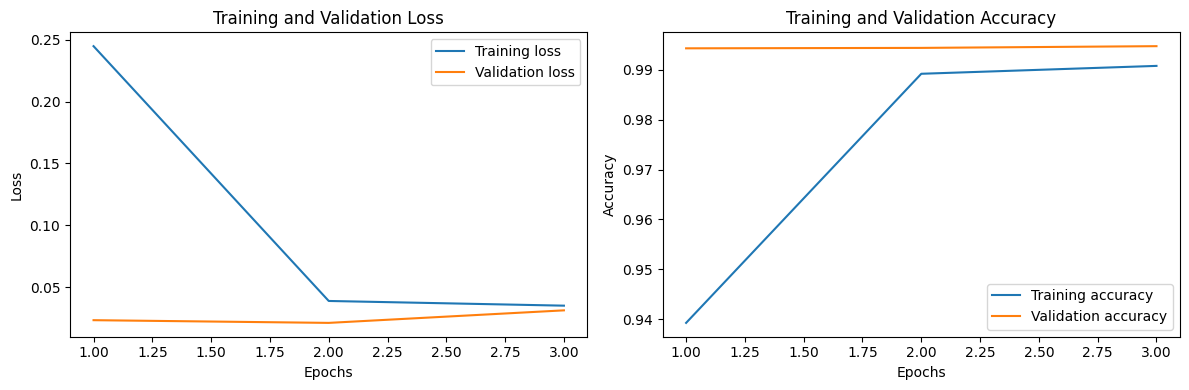

In [40]:
show_history(history.history)

### Tests

In [41]:
loss, accuracy = model.evaluate(X_test, y_test_categorical)
print("Accuracy on test : ", accuracy)

362/362 [==============================] - 4s 9ms/step - loss: 0.0245 - accuracy: 0.9955
Accuracy on test :  0.9955036640167236


The model is good, but surprisingly not better than the previous CNN.

## LSTM

I will also try to implement a recurrent neural network.  
As the data is sequential, they are appropriate for this classification problem. Additionally, the current algorithm used for Pfam (HMMs) work with the data in a sequential way.  
Moreover, it aligns with the methodology used by _Strodthoff et al. (2020)_ and _Bileschi et al. (2019)_.

### Model creation

In [42]:
class ProteinLSTM(tf.keras.Model):
    def __init__(self, num_classes, input_dim, embedding_output_dim, input_length, nb_lstm_units=64, nb_dense_units=256, use_attention=False, pooling_strategy='max_pooling', dropout_rate=0.2, embedding_by_position=False, mask_zero=True, **kwargs):
        """
            This class represents a LSTM based neural network model.
            It consists of a bidirectional LSTM, followed by a dot-attention layer, and two dense layers.

            Args:
                num_classes (int): Number of target classes for classification.
                input_dim (int): The input dimension, representing the total number of unique amino acids.
                embedding_output_dim (int): The output dimension of the embedding layer.
                input_length (int): The input length, typically the maximum sequence length for protein sequences.
                nb_lstm_units (int, optional): The number of LSTM units to use. Default is 64.
                nb_dense_units (int, optional): The number of units in the dense layer after LSTM. Default is 256.
                use_attention (bool, optional): Whether to use attention mechanism in the model. Default is False.
                pooling_strategy (str, optional): The pooling strategy to use after LSTM and attention 
                                                  (options: 'max_pooling', 'average_pooling', 'cls', 'flatten'; default is 'max_pooling').
                dropout_rate (float, optional): The dropout rate to apply (default is 0.2).
                embedding_by_position (bool, optional): Whether embedding is done by position (default is False).
                mask_zero (bool, optional): Whether to mask the input (used for variable-length sequences; default is True).
                **kwargs: Additional keyword arguments to pass to the parent class initializer.
            """
        super().__init__()
        self.embedding_layer = EmbeddingLayer(input_dim=input_dim,
                                              embedding_output_dim=embedding_output_dim,
                                              input_length=input_length,
                                              embedding_by_position=embedding_by_position,
                                              mask_zero=mask_zero)

        return_sequences = use_attention
        self.use_attention = use_attention
        self.pooling_strategy = pooling_strategy

        self.lstm_layer = layers.Bidirectional(layers.LSTM(units=nb_lstm_units, return_sequences=use_attention, dropout=dropout_rate))
        self.attention = layers.Attention()
        self.dense = layers.Dense(nb_dense_units, activation='relu')
        self.dropout = layers.Dropout(dropout_rate)
        self.dense_softmax = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        x = self.embedding_layer(inputs)
        x = self.lstm_layer(x)

        if self.use_attention:
            mask = tf.math.logical_not(tf.math.equal(inputs, 0))
            x = self.attention([x, x], mask=[mask, mask])
            x = self.pooling(x, mask=mask)

        x = self.dense(x)
        x = self.dropout(x, training)
        x = self.dense_softmax(x)
        return x

    def pooling(self, x, mask=None):
        if self.pooling_strategy == 'max_pooling':
            x = tf.reduce_max(x, axis=1)

        elif self.pooling_strategy == 'average_pooling':
            mask = tf.expand_dims(tf.cast(mask, x.dtype), axis=-1)
            masked_sum = tf.reduce_sum(x * mask, axis=1)
            num_non_masked = tf.reduce_sum(mask, axis=1)
            x = masked_sum / (num_non_masked + 1e-8)

        elif self.pooling_strategy == 'cls':
            x = x[:, 0, :]

        elif self.pooling_strategy == 'flatten':
            x = layers.Flatten()(x)

        return x

    def get_embedding_before_classification(self, inputs, training=False):
        x = self.embedding_layer(inputs)
        x = self.lstm_layer(x)
        x = self.dense(x)
        x = self.dropout(x, training)
        return x

# Testing the LSTM model
def _test():
    embedding_params = {
        'embedding_output_dim': 20,
        'embedding_by_position': True,
        'mask_zero': True
    }
    model_params = {
        'nb_lstm_units': 64,
        'nb_dense_units': 256,
        'dropout_rate': 0.2,
        'use_attention': True,
        'pooling_strategy': 'average_pooling'
    }

    input_shape = (data_params['input_length'],)
    expected_output_shape = (data_params['num_classes'],)

    _test_model(ProteinLSTM, data_params, embedding_params, model_params, input_shape, expected_output_shape, batch_size=8)

_test()


Providing the model with input of shape: (8, 300)
Expected output: (8, 100)
Test passed


### Gridsearch

In [ ]:
embedding_params = {
    'embedding_output_dim': 128,
    'embedding_by_position': False,
    'mask_zero': True,
}
model_params = {
    'nb_lstm_units': 64,
    'nb_dense_units': 128,
    'dropout_rate': 0.2,
    'use_attention': True,
    'pooling_strategy': 'max_pooling'
}
training_params = {
    'learning_rate': 1e-3,
    'batch_size': 32,
    'epochs': 50,
    'early_stopping_patience': 2,
    'validation_data': (X_dev, y_dev_categorical),
    'class_weight': class_weight_dict
}

gridsearch_params = {
    'embedding_params': {
        'embedding_output_dim': [64, 128, 256]
    },
    'model_params': {
        'nb_lstm_units': [64, 128],
        'pooling_strategy': ['average_pooling', 'flatten']
    },
    'training_params': {
    }
}

In [49]:
"""
best_params, best_score = gridsearch(ProteinLSTM,
                                     X_train[:30000],
                                     y_train_categorical[:30000],
                                     gridsearch_params,
                                     metric='loss',
                                     verbose='auto',
                                     **data_params,
                                     **embedding_params,
                                     **model_params,
                                     **training_params)
"""

"\nbest_params, best_score = gridsearch(ProteinLSTM,\n                                     X_train[:30000],\n                                     y_train_categorical[:30000],\n                                     gridsearch_params,\n                                     metric='loss',\n                                     verbose='auto',\n                                     **data_params,\n                                     **embedding_params,\n                                     **model_params,\n                                     **training_params)\n"

### Best hyperparameters

In [51]:
embedding_params = {
    'embedding_output_dim': 128,
    'embedding_by_position': False,
    'mask_zero': True,
}
model_params = {
    'nb_lstm_units': 64,
    'nb_dense_units': 128,
    'dropout_rate': 0.2,
    'use_attention': True,
    'pooling_strategy': 'flatten'
}
training_params = {
    'learning_rate': 1e-3,
    'batch_size': 64,
    'epochs': 50,
    'early_stopping_patience': 1,
    'validation_data': (X_dev, y_dev_categorical),
    'class_weight': class_weight_dict
}

### Train

In [52]:
model = ProteinLSTM(**data_params, **embedding_params, **model_params)
history = compile_and_train_model(model, X_train, y_train_categorical, **training_params)

Epoch 1/50
1453/1453 [==============================] - 62s 36ms/step - loss: 0.6908 - accuracy: 0.8052 - val_loss: 0.0507 - val_accuracy: 0.9866
Epoch 2/50
1453/1453 [==============================] - 50s 34ms/step - loss: 0.0767 - accuracy: 0.9777 - val_loss: 0.0297 - val_accuracy: 0.9918
Epoch 3/50
1453/1453 [==============================] - 50s 35ms/step - loss: 0.0390 - accuracy: 0.9883 - val_loss: 0.0275 - val_accuracy: 0.9939
Epoch 4/50
1453/1453 [==============================] - 50s 34ms/step - loss: 0.0302 - accuracy: 0.9908 - val_loss: 0.0267 - val_accuracy: 0.9940
Epoch 5/50
1453/1453 [==============================] - 50s 35ms/step - loss: 0.0225 - accuracy: 0.9932 - val_loss: 0.0218 - val_accuracy: 0.9952
Epoch 6/50
1453/1453 [==============================] - 50s 35ms/step - loss: 0.0200 - accuracy: 0.9944 - val_loss: 0.0269 - val_accuracy: 0.9956


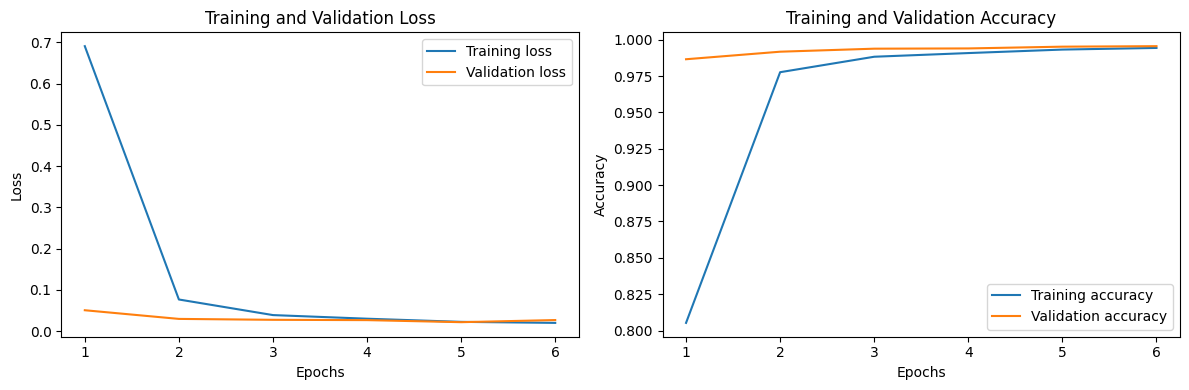

In [54]:
show_history(history.history)

### Tests

In [55]:
loss, accuracy = model.evaluate(X_test, y_test_categorical)
print("Accuracy on test : ", accuracy)

362/362 [==============================] - 4s 11ms/step - loss: 0.0241 - accuracy: 0.9950
Accuracy on test :  0.9949848651885986


The results are good, but not better than the ones obtained with the other architectures.

## Transformer

Lastly, I will explore the implementation of a Transformer model.   
Transformers have demonstrated remarkable success in Natural Language Processing. They are very good with sequential data tasks.  

This aligns with the approach of _Brandes et al. (2022)_ (they developed a model they called ProteinBERT).  
Nevertheless, unlike their approach, I could not perform pretraining (they pretrained the model like BERT was pretrained) due to limitations in computational resources.  
This is why I only trained the model on the current Pfam dataset.

### Model creation

In [56]:
class TransformerBlock(tf.keras.Model):
    def __init__(self, num_heads, dim_heads, latent_dim, mlp_dim, dropout_rate=0.1, **kwargs):
        """
        This class implements a standard Transformer block from the Encoder, as described in the paper "Attention Is All You Need".
        It consists of a multi-head self-attention layer and a position-wise feed-forward neural network.
        Each of these two components has a residual connection around it, followed by layer normalization.

        Args:
            num_heads (int): Number of attention heads in the multi-head attention layer.
            dim_heads (int): Dimensionality of each attention head.
            latent_dim (int): The dimensionality of the input and output of the block.
            mlp_dim (int): Dimensionality of the inner layer of the two feed-forward neural networks in the block.
            dropout_rate (float, optional): Dropout rate used for regularization. Default is 0.1.

        """
        super().__init__()
        self.multi_head_attention_layer = layers.MultiHeadAttention(num_heads=num_heads, key_dim=dim_heads)
        self.dense1 = layers.Dense(mlp_dim, activation='relu')
        self.dense2 = layers.Dense(latent_dim, activation='relu')
        self.layer_norm1 = layers.LayerNormalization()
        self.layer_norm2 = layers.LayerNormalization()
        self.dropout = layers.Dropout(dropout_rate)

    def __call__(self, inputs, training=False, attention_mask=None):
        x = self.layer_norm1(inputs)

        attention_output = self.multi_head_attention_layer(x, x, attention_mask=attention_mask)
        attention_output += x

        y = self.layer_norm2(attention_output)
        y = self.dense1(y)
        y = self.dropout(y, training=training)
        y = self.dense2(y)
        y = self.dropout(y, training=training)

        return y + attention_output

def _test():
    embedding_params = {
        'embedding_output_dim': 20,
        'embedding_by_position': False,
    }
    model_params = {
        'latent_dim': 20,
        'num_heads': 8,
        'dim_heads': 16,
        'mlp_dim': 30,
        'dropout_rate': 0.2
    }

    input_shape = (data_params['input_length'], embedding_params['embedding_output_dim'])
    expected_output_shape = (data_params['input_length'], embedding_params['embedding_output_dim'])

    _test_model(TransformerBlock, data_params, embedding_params, model_params, input_shape, expected_output_shape, batch_size=32)

_test()

Providing the model with input of shape: (32, 300, 20)
Expected output: (32, 300, 20)
Test passed


In [57]:
class Transformer(tf.keras.Model):
    def __init__(self, num_classes, input_dim, embedding_output_dim, input_length, num_layers, num_heads, dim_heads, nb_dense_units=2566, mlp_dim=128, dropout_rate=0.1, embedding_by_position=True, pooling_strategy='cls', padding_token=0, mask_zero=True, **kwargs):
        """
        This class implements a Transformer model.
        The model consists of an embedding layer followed by several Transformer blocks and a final dense layer for classification.

        Args:
            num_classes (int): Number of target classes for classification.
            input_dim (int): The input dimension, typically representing the size of the vocabulary.
            embedding_output_dim (int): The dimensionality of the output space of the embedding layer.
            input_length (int): The length of the input sequences.
            num_layers (int): The number of Transformer blocks to be stacked.
            num_heads (int): Number of attention heads in each Transformer block.
            dim_heads (int): Dimensionality of each attention head.
            nb_dense_units (int, optional): The number of units in the final dense layer. Default is 256.
            mlp_dim (int, optional): Dimensionality of the inner layer of the feed-forward networks in the blocks. Default is 128.
            dropout_rate (float, optional): Dropout rate used for regularization. Default is 0.1.
            embedding_by_position (bool, optional): Whether to include positional embeddings. Default is True.
            pooling_strategy (str, optional): Strategy for pooling the output of the Transformer. Options are 'max_pooling',
                                              'average_pooling', 'cls', and 'flatten'. Default is 'cls'.
            padding_token (int, optional): The token used for the padding. It is used for the attention mask. Default is 0.

        """
        super().__init__()

        self.embedding_layer = EmbeddingLayer(input_dim=input_dim,
                                              embedding_output_dim=embedding_output_dim,
                                              input_length=input_length,
                                              embedding_by_position=embedding_by_position,
                                              mask_zero=mask_zero)

        self.encoder_blocks = [TransformerBlock(num_heads=num_heads,
                                                dim_heads=dim_heads,
                                                latent_dim=embedding_output_dim,
                                                mlp_dim=mlp_dim,
                                                dropout_rate=dropout_rate) for _ in range(num_layers)]

        self.dense = layers.Dense(nb_dense_units, activation='relu')
        self.dense_softmax = layers.Dense(num_classes, activation='softmax')
        self.dropout = layers.Dropout(dropout_rate)

        available_pooling_strategies = ['max_pooling', 'average_pooling', 'cls', 'flatten']
        assert pooling_strategy in available_pooling_strategies, f"Pooling strategy must be in {available_pooling_strategies}, not {pooling_strategy}"
        self.pooling_strategy = pooling_strategy

        self.padding_token = padding_token

    def __call__(self, inputs, training=False):
        x = self.embedding_layer(inputs)
        x = self.dropout(x, training=training)

        attention_mask = tf.cast(tf.math.not_equal(inputs, self.padding_token), dtype=tf.float32)
        attention_mask = tf.expand_dims(attention_mask, axis=1)

        for encoder in self.encoder_blocks:
            x = encoder(x, training=training, attention_mask=attention_mask)

        x = self.pooling(x, mask=attention_mask)
        x = self.dense_softmax(x)

        return x

    def pooling(self, x, mask=None):
        if self.pooling_strategy == 'max_pooling':
            x = tf.reduce_max(x, axis=1)

        elif self.pooling_strategy == 'average_pooling':
            mask = tf.expand_dims(tf.cast(mask, x.dtype), axis=-1)
            masked_sum = tf.reduce_sum(x * mask, axis=1)
            num_non_masked = tf.reduce_sum(mask, axis=1)
            x = masked_sum / (num_non_masked + 1e-8)

        elif self.pooling_strategy == 'cls':
            x = x[:, 0, :]

        elif self.pooling_strategy == 'flatten':
            x = layers.Flatten()(x)

        return x

    def get_embedding_before_classification(self, inputs, training=False):
        x = self.embedding_layer(inputs)
        x = self.dropout(x, training=training)

        attention_mask = tf.cast(tf.math.not_equal(inputs, self.padding_token), dtype=tf.float32)
        attention_mask = tf.expand_dims(attention_mask, axis=1)

        for encoder in self.encoder_blocks:
            x = encoder(x, training=training, attention_mask=attention_mask)

        x = self.pooling(x)

        return x


def _test():
    embedding_params = {
        'embedding_output_dim': 50,
        'embedding_by_position': True,
        'mask_zero': True
    }
    model_params = {
        'num_layers': 4,
        'num_heads': 8,
        'dim_heads': 16,
        'mlp_dim': 30,
        'dropout_rate': 0.2,
        'pooling_strategy': 'max_pooling'
    }

    input_shape = (data_params['input_length'],)
    expected_output_shape = (data_params['num_classes'],)

    _test_model(Transformer, data_params, embedding_params, model_params, input_shape, expected_output_shape, batch_size=8)

_test()

Providing the model with input of shape: (8, 300)
Expected output: (8, 100)
Test passed


### Gridsearch

In [ ]:
embedding_params = {
    'embedding_output_dim': 20,
    'embedding_by_position': True,
    'mask_zero': True,
}
model_params = {
    'num_layers': 2,
    'num_heads': 4,
    'dim_heads': 8,
    'mlp_dim': 64,
    'dropout_rate': 0.2,
    'nb_dense_units': 128,
    'pooling_strategy': 'cls'
}
training_params = {
    'learning_rate': 1e-2, # I noticed that training is faster and better using 1e-2 instead of 1e-3
    'batch_size': 32,
    'epochs': 50,
    'early_stopping_patience': 2,
    'validation_data': (X_dev, y_dev_categorical),
    'class_weight': class_weight_dict
}

gridsearch_params = {
    'embedding_params': {
    },
    'model_params': {
        'num_heads': [4, 8],
        'pooling_strategy': ['cls', 'max_pooling', 'average_pooling']
    },
    'training_params': {
    }
}

In [ ]:
"""
best_params, best_score = gridsearch(Transformer,
                                     add_cls_token(X_train[:30000], data_params['input_dim']),
                                     y_train_categorical[:30000],
                                     gridsearch_params,
                                     metric='loss',
                                     verbose='auto',
                                     **data_params,
                                     **embedding_params,
                                     **model_params,
                                     **training_params)
"""

"\nbest_params, best_score = gridsearch(Transformer,\n                                     add_cls_token(X_train[:30000], data_params['input_dim']),\n                                     y_train_categorical[:30000],\n                                     gridsearch_params,\n                                     metric='loss',\n                                     verbose='auto',\n                                     **data_params,\n                                     **embedding_params,\n                                     **model_params,\n                                     **training_params)\n"

### Best hyperparameters

In [59]:
embedding_params = {
    'embedding_output_dim': 256,
    'embedding_by_position': True,
    'mask_zero': True
}
model_params = {
    'num_layers': 2,
    'num_heads': 8,
    'dim_heads': 64,
    'mlp_dim': 512,
    'dropout_rate': 0.3,
    'pooling_strategy': 'cls'
}
training_params = {
    'learning_rate': 1e-2,
    'batch_size': 32,
    'epochs': 50,
    'early_stopping_patience': 1,
    'validation_data': (X_dev, y_dev_categorical),
    'class_weight': class_weight_dict
}

### Train

In [60]:
model = Transformer(**data_params, **embedding_params, **model_params)
history = compile_and_train_model(model, X_train, y_train_categorical, **training_params)

Epoch 1/50
727/727 [==============================] - 141s 184ms/step - loss: 4.5164 - accuracy: 0.1479 - val_loss: 2.5567 - val_accuracy: 0.2827
Epoch 2/50
727/727 [==============================] - 134s 184ms/step - loss: 1.9934 - accuracy: 0.4282 - val_loss: 1.5577 - val_accuracy: 0.5908
Epoch 3/50
727/727 [==============================] - 134s 184ms/step - loss: 1.1285 - accuracy: 0.6901 - val_loss: 0.7880 - val_accuracy: 0.8047
Epoch 4/50
727/727 [==============================] - 133s 184ms/step - loss: 0.6960 - accuracy: 0.8105 - val_loss: 0.7452 - val_accuracy: 0.8265
Epoch 5/50
727/727 [==============================] - 134s 184ms/step - loss: 0.6359 - accuracy: 0.8289 - val_loss: 0.7463 - val_accuracy: 0.8414


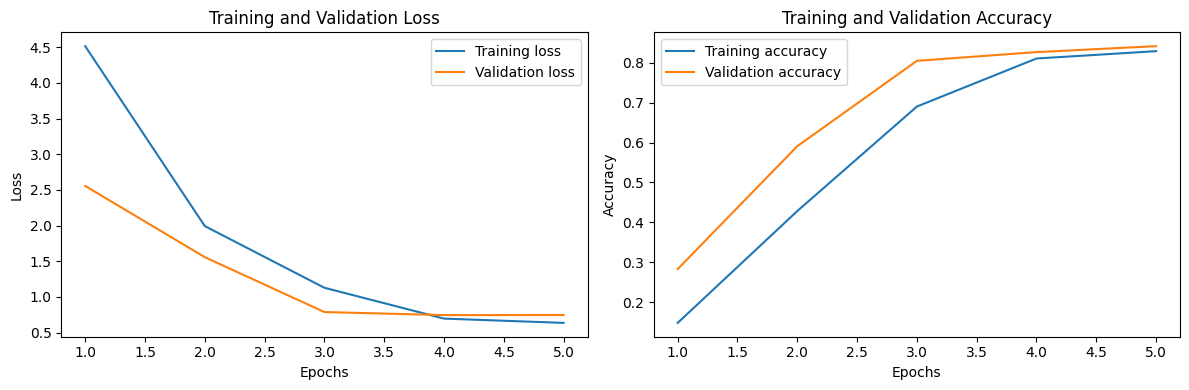

In [61]:
show_history(history.history)

### Tests

In [62]:
loss, accuracy = model.evaluate(X_test, y_test_categorical)
print("Accuracy on test : ", accuracy)

362/362 [==============================] - 8s 21ms/step - loss: 0.7763 - accuracy: 0.8364
Accuracy on test :  0.836402952671051


The model doesn't work well at all.  
I may be able to improve the results by pretraining the model (in a similar way than BERT), but I have limitations in computational resources, so I will not try to do it.

# Ensemble method

Among the model we tested, the CNN yielded the best results.  
We will try to use it in an ensemble classifier, to assess whether it will improve the results.

## Model creation

In [66]:
class EnsembleClassifier:
    def __init__(self, base_model, num_models, *args, **kwargs):
        """
        Initialize an ensemble of classification models.

        Args:
            base_model (class): The base model class to use for creating each model in the ensemble.
            num_models (int): The number of models in the ensemble.
            *args: Positional arguments to be passed when creating the models.
            **kwargs: Keyword arguments to be passed when creating the models.

        """
        self.models = []
        self.base_model = base_model
        self.num_models = num_models
        self.args = args
        self.kwargs = kwargs

        for _ in range(num_models):
            model = self.base_model(*self.args, **self.kwargs)
            self.models.append(model)

    def compile(self, optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']):
        for model in self.models:
            model.compile(optimizer=optimizer,
                          loss=loss,
                          metrics=metrics)

    def fit(self, X, y_categorical, epochs, batch_size, early_stopping_patience, validation_data=None, class_weight=None, **kwargs):
        early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                       min_delta=0,
                                                       patience=early_stopping_patience,
                                                       verbose=0,
                                                       mode='auto')

        for i, model in enumerate(self.models):
            print(f"Training model {i+1}/{len(self.models)}...")
            indices = np.random.choice(len(X), size=len(X))
            X_bootstrap = X[indices]
            y_categorical_bootstrap = y_categorical[indices]
            model.fit(X_bootstrap,
                      y_categorical_bootstrap,
                      epochs=epochs,
                      batch_size=batch_size,
                      validation_data=validation_data,
                      class_weight=class_weight,
                      callbacks=[early_stopping])

    def compute_accuracy(self, X, y, num_classes):
        predictions = [model.predict(X) for model in self.models]
        all_predictions = np.array(predictions)
        result = np.zeros((self.num_models, X.shape[0], num_classes))

        for i in range(self.num_models):
            predictions_for_i_models = all_predictions[:i+1]
            mean_predictions = np.mean(predictions_for_i_models, axis=0)
            result[i] = mean_predictions

        preds_by_group_of_models = np.argmax(result, axis=2)
        list_accuracy = []

        for y_preds in preds_by_group_of_models:
            list_accuracy.append(sklearn.metrics.accuracy_score(y_preds, y_test))

        return list_accuracy

### Hyperparameters

For the hyperparameters, I simply used the better hyperparameters I found for the CNN.

In [67]:
base_model = CNN
num_models = 15

embedding_params = {
    'embedding_output_dim': 20,
    'embedding_by_position': False,
    'mask_zero': True,
}
model_params = {
    'nb_filters_per_kernel_size': 32,
    'kernel_sizes': [7, 11, 15, 17, 19, 21, 23, 25],
    'nb_dense_units': 256,
    'dropout_rate': 0.3
}
training_params = {
    'learning_rate': 1e-3,
    'batch_size': 32,
    'epochs': 30,
    'early_stopping_patience': 1,
    'validation_data': (X_dev, y_dev_categorical),
    'class_weight': class_weight_dict
}

### Train

In [68]:
ensemble_model = EnsembleClassifier(base_model, num_models=num_models, **data_params, **embedding_params, **model_params)

ensemble_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(training_params['learning_rate']),
                       loss='categorical_crossentropy',
                       metrics=['accuracy']) # sparse_categorical_crossentropy

ensemble_model.fit(X_train,
                   y_train_categorical,
                   **training_params)

Training model 1/15...
Epoch 1/30
727/727 [==============================] - 14s 17ms/step - loss: 0.2923 - accuracy: 0.9311 - val_loss: 0.0226 - val_accuracy: 0.9943
Epoch 2/30
727/727 [==============================] - 12s 17ms/step - loss: 0.0122 - accuracy: 0.9968 - val_loss: 0.0135 - val_accuracy: 0.9961
Epoch 3/30
727/727 [==============================] - 12s 17ms/step - loss: 0.0065 - accuracy: 0.9983 - val_loss: 0.0151 - val_accuracy: 0.9963
Training model 2/15...
Epoch 1/30
727/727 [==============================] - 14s 17ms/step - loss: 0.1685 - accuracy: 0.9610 - val_loss: 0.0176 - val_accuracy: 0.9955
Epoch 2/30
727/727 [==============================] - 13s 18ms/step - loss: 0.0068 - accuracy: 0.9980 - val_loss: 0.0163 - val_accuracy: 0.9961
Epoch 3/30
727/727 [==============================] - 12s 17ms/step - loss: 0.0042 - accuracy: 0.9990 - val_loss: 0.0149 - val_accuracy: 0.9964
Epoch 4/30
727/727 [==============================] - 12s 17ms/step - loss: 0.0027 - accur

### Tests

In [69]:
accuracy_list = ensemble_model.compute_accuracy(X_test, y_test, num_classes=data_params['num_classes'])

362/362 [==============================] - 1s 2ms/step


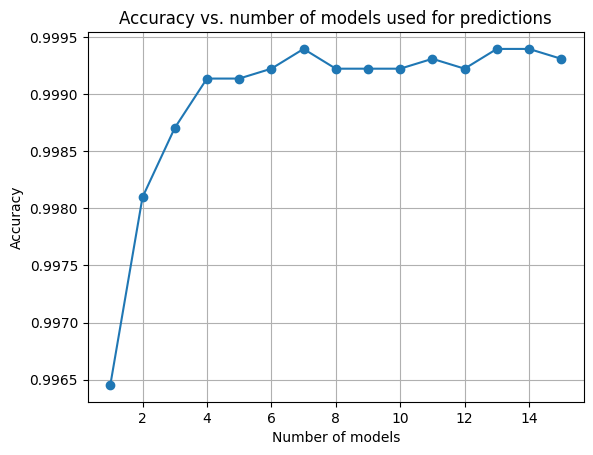

In [70]:
best_accuracy_index = np.argmax(accuracy_list)
best_accuracy = accuracy_list[best_accuracy_index]

plt.plot(range(1, len(accuracy_list) + 1), accuracy_list, marker='o', linestyle='-')
plt.xlabel('Number of models')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. number of models used for predictions')
plt.grid(True)

plt.show()

In [71]:
print(f"Best accuracy : {best_accuracy}\nObtained with {best_accuracy_index + 1} models\n")

Best accuracy : 0.9993947254647644
Obtained with 7 models



The performance is even better with multiples CNNs.  
Now, let us try this architecture on the whole Pfam dataset.

# Work with all the classes of Pfam dataset

In this section, I will first train a CNN on the whole dataset to assess the performance of a single CNN.  
Then, I will use an ensemble method to enhance performance.

## A single model trained on the whole dataset

### Data parameters

In [72]:
sequences_length = 300
num_classes = len(df_train['label'].unique())
padding = 'post'
print("Number of classes : ", num_classes)

Number of classes :  17929


In [73]:
data_params = {
    'input_dim': len(amino_acids_to_keep) + 2, # We add 1 for the token used for padding, and 1 for the token used for 'CLS'
    'input_length': sequences_length,
    'num_classes': num_classes
}

### Data preparation

In [74]:
X_train = np.array(df_train['sequence_encoded'].to_list())
y_train = df_train['label'].to_numpy()

X_dev = np.array(df_dev['sequence_encoded'].to_list())
y_dev = df_dev['label'].to_numpy()

X_test = np.array(df_test['sequence_encoded'].to_list())
y_test = df_test['label'].to_numpy()

In [75]:
weights_train = sklearn.utils.class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(weights_train))

### Train function

I implemented the training differently than before due to memory RAM issues.  The use of y_categorical requires too much storage, so I re-implemented the training loop.

In [77]:
def train_model(model, X_train, y_train, X_dev, y_dev, num_classes, num_epochs, batch_size, learning_rate, loss_fn, patience, class_weight_dict=None):
    """
    Trains a neural network model.

    Args:
    - model: The neural network model to be trained.
    - X_train: Training data features.
    - y_train: Training data labels.
    - X_dev: Validation data features.
    - y_dev: Validation data labels.
    - num_classes: Number of output classes.
    - num_epochs: Number of training epochs.
    - batch_size: Batch size for training.
    - learning_rate: Learning rate for the optimizer (Adam).
    - loss_fn: Loss function used for training.
    - patience: Number of epochs to wait for improvement before triggering early stopping.
    - class_weight_dict: A dictionary containing class weights (optional). Default is None

    Returns:
    - history: A dictionary containing training history metrics.
    
    """
    best_val_loss = float('inf')
    early_stopping_triggered = False

    history = {metric: [] for metric in ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

    optimizer = tf.keras.optimizers.Adam(learning_rate)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train_accuracy = 0
        test_accuracy = 0
        
        # Train data
        for i in tqdm(range(0, len(X_train), batch_size)):
            x_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            sample_weight = None
            if class_weight_dict is not None:
                sample_weight = np.array([class_weight_dict[label] for label in y_batch])

            with tf.GradientTape() as tape:
                y_pred = model(x_batch, training=True)
                loss_value = loss_fn(keras.utils.to_categorical(y_batch, num_classes=num_classes), y_pred, sample_weight=sample_weight)

            gradients = tape.gradient(loss_value, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            train_accuracy += np.sum(np.argmax(y_pred, axis=1) == y_batch)

        train_accuracy = train_accuracy / len(X_train) * 100
        
        # Validation data
        val_loss = 0.0
        val_batches = 0
        for i in tqdm(range(0, len(X_dev), batch_size)):
            x_dev_batch = X_dev[i:i+batch_size]
            y_dev_batch = y_dev[i:i+batch_size]

            y_dev_pred = model(x_dev_batch, training=False)

            val_loss += loss_fn(keras.utils.to_categorical(y_dev_batch, num_classes=num_classes), y_dev_pred)
            val_batches += 1

            test_accuracy += np.sum(np.argmax(y_dev_pred, axis=1) == y_dev_batch)

        test_accuracy = test_accuracy / len(X_test) * 100

        val_loss /= val_batches

        # Store losses
        history['loss'].append(loss_value.numpy())
        history['accuracy'].append(train_accuracy)
        history['val_loss'].append(val_loss.numpy())
        history['val_accuracy'].append(test_accuracy)

        print(f"loss: {loss_value.numpy():.4f}, accuracy: {train_accuracy:.4f}, val_loss: {val_loss.numpy():.4f}, val_accuracy: {test_accuracy:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print("\nEarly stopping triggered. Training will stop.")
                early_stopping_triggered = True
                break

    return history

### Model with two convolutional layers

#### Hyperparameters

In [ ]:
embedding_params = {
    'embedding_output_dim': 64,
    'embedding_by_position': False,
    'mask_zero': True,
}
model_params = {
    'num_conv_layers': 2,
    'nb_filters_per_kernel_size': 32,
    'kernel_sizes': [7, 11, 15, 17, 19, 21, 23, 25],
    'nb_dense_units': 1024,
    'dropout_rate': 0.3
}

In [ ]:
num_epochs = 50
batch_size = 64 # Low batch size due to memory RAM constraints

learning_rate = 1e-3
loss_fn = tf.keras.losses.CategoricalCrossentropy()

patience = 1
class_weight = None

#### Train model

In [99]:
model = CNN(**data_params, **embedding_params, **model_params)

In [103]:
history = train_model(model, X_train, y_train, X_dev, y_dev, num_classes, num_epochs, batch_size, learning_rate, loss_fn, patience, class_weight_dict=class_weight)

Epoch 1/50


100%|██████████| 124/124 [00:30<00:00,  4.11it/s]


loss: 1.0088, accuracy: 42.7511, val_loss: 0.6656, val_accuracy: 86.9653
Epoch 2/50


100%|██████████| 124/124 [00:28<00:00,  4.37it/s]


loss: 0.1863, accuracy: 84.4036, val_loss: 0.3091, val_accuracy: 93.7569
Epoch 3/50


100%|██████████| 124/124 [00:28<00:00,  4.34it/s]


loss: 0.0938, accuracy: 91.5918, val_loss: 0.2409, val_accuracy: 95.0813
Epoch 4/50


100%|██████████| 124/124 [00:28<00:00,  4.34it/s]


loss: 0.0448, accuracy: 94.4897, val_loss: 0.2214, val_accuracy: 95.7098
Epoch 5/50


100%|██████████| 124/124 [00:28<00:00,  4.34it/s]


loss: 0.0682, accuracy: 95.9145, val_loss: 0.2100, val_accuracy: 95.9705
Epoch 6/50


100%|██████████| 124/124 [00:29<00:00,  4.21it/s]


loss: 0.0279, accuracy: 96.8697, val_loss: 0.2088, val_accuracy: 96.1727
Epoch 7/50


100%|██████████| 124/124 [00:29<00:00,  4.27it/s]


loss: 0.0246, accuracy: 97.3833, val_loss: 0.1987, val_accuracy: 96.4065
Epoch 8/50


100%|██████████| 124/124 [00:28<00:00,  4.29it/s]

loss: 0.0197, accuracy: 97.8791, val_loss: 0.2004, val_accuracy: 96.5674

Early stopping triggered. Training will stop.


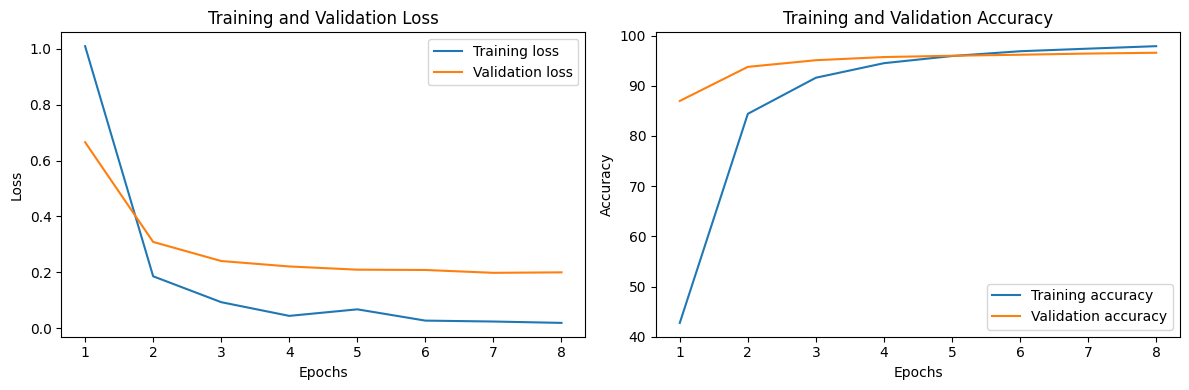

In [104]:
show_history(history)

#### Tests

In [106]:
batch_size = 64

correct_predictions = 0
total_predictions = 0

for i in tqdm(range(0, len(X_test), batch_size)):
    x_test_batch = X_test[i:i+batch_size]
    y_test_batch = y_test[i:i+batch_size]

    y_test_pred = model(x_test_batch, training=False)

    y_test_pred_classes = tf.argmax(y_test_pred, axis=1)
    correct_predictions += tf.reduce_sum(tf.cast(tf.equal(y_test_pred_classes, y_test_batch), tf.int32))
    total_predictions += len(y_test_batch)

accuracy = correct_predictions / total_predictions
print(f"\nAccuracy: {accuracy.numpy()}")

100%|██████████| 986/986 [00:40<00:00, 24.11it/s]


Accuracy: 0.9650474356230829


Initially, I evaluated the model using a lighter architecture, which achieved an accuracy of approximately 91%.  
When I used a larger model, the accuracy improved significantly, reaching 96.5%.  

It's possible that further optimization of hyperparameters could lead to even better performance.  
However, due to computational limitations, I couldn't explore additional hyperparameter tuning, especially considering that the final model will be part of an ensemble method.

### Model with only one convolutional layer

#### Hyperparameters

In [84]:
embedding_params = {
    'embedding_output_dim': 64,
    'embedding_by_position': False,
    'mask_zero': True,
}
model_params = {
    'nb_filters_per_kernel_size': 64,
    'kernel_sizes': [7, 11, 15, 17, 19, 21, 23, 25],
    'nb_dense_units': 1024,
    'dropout_rate': 0.3
}

In [ ]:
num_epochs = 50
batch_size = 64 # Low batch size because of memory RAM constraints

learning_rate = 1e-3
loss_fn = tf.keras.losses.CategoricalCrossentropy()

patience = 1
class_weight = None # class_weight_dict

#### Train model

In [85]:
model = CNN(**data_params, **embedding_params, **model_params)

In [87]:
history = train_model(model, X_train, y_train, X_dev, y_dev, num_classes, num_epochs, batch_size, learning_rate, loss_fn, patience, class_weight_dict=class_weight)

Epoch 1/50


100%|██████████| 124/124 [00:26<00:00,  4.68it/s]


loss: 0.5031, accuracy: 61.2799, val_loss: 0.3424, val_accuracy: 93.4105
Epoch 2/50


100%|██████████| 124/124 [00:26<00:00,  4.74it/s]


loss: 0.0529, accuracy: 92.6427, val_loss: 0.2148, val_accuracy: 95.6955
Epoch 3/50


100%|██████████| 124/124 [00:25<00:00,  4.91it/s]


loss: 0.0086, accuracy: 96.9160, val_loss: 0.2118, val_accuracy: 96.0744
Epoch 4/50


100%|██████████| 124/124 [00:27<00:00,  4.59it/s]

loss: 0.0296, accuracy: 97.9641, val_loss: 0.2225, val_accuracy: 96.2178

Early stopping triggered. Training will stop.


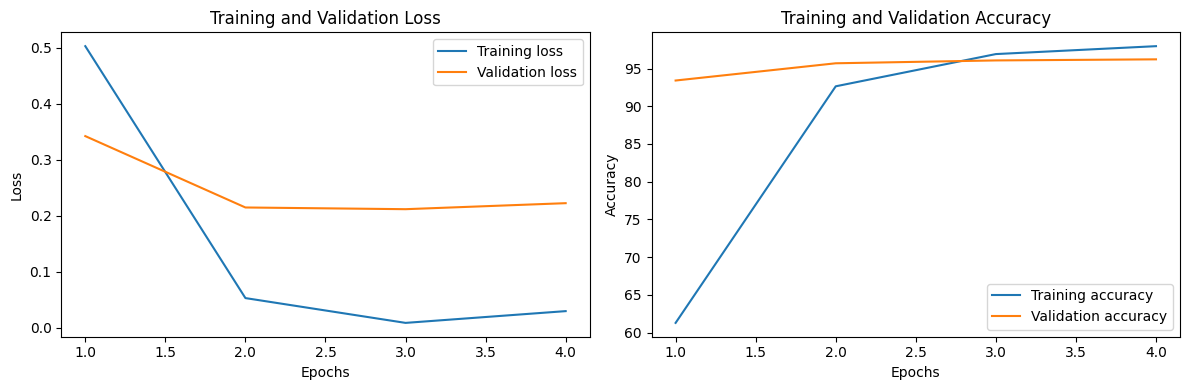

In [89]:
show_history(history)

#### Tests

In [88]:
batch_size = 64
correct_predictions = 0
total_predictions = 0

for i in tqdm(range(0, len(X_test), batch_size)):
    x_test_batch = X_test[i:i+batch_size]
    y_test_batch = y_test[i:i+batch_size]

    y_test_pred = model(x_test_batch, training=False)

    y_test_pred_classes = tf.argmax(y_test_pred, axis=1)
    correct_predictions += tf.reduce_sum(tf.cast(tf.equal(y_test_pred_classes, y_test_batch), tf.int32))
    total_predictions += len(y_test_batch)

accuracy = correct_predictions / total_predictions
print(f"\nAccuracy: {accuracy.numpy()}")

100%|██████████| 986/986 [02:00<00:00,  8.18it/s]


Accuracy: 0.9612978532169929


While the accuracy is lower with just one convolutional layer, I have decided to retain this architecture for the ensemble method.  
This decision is driven by the significant computational time required for training a model with more than one convolutional layer, which I do not have unlimited access to.

## Ensemble method on the whole dataset

In [120]:
class EnsembleClassifier:
    def __init__(self, base_model, num_models, *args, **kwargs):
        """
        Initialize an ensemble of classification models.

        Args:
            base_model (class): The base model class to use for creating each model in the ensemble.
            num_models (int): The number of models in the ensemble.
            *args: Positional arguments to be passed when creating the models.
            **kwargs: Keyword arguments to be passed when creating the models.

        """
        self.models = []
        self.base_model = base_model
        self.num_models = num_models
        self.args = args
        self.kwargs = kwargs

        for _ in range(num_models):
            model = self.base_model(*self.args, **self.kwargs)
            self.models.append(model)

    def fit(self, X, y, X_val, y_val, num_classes, num_epochs, batch_size, learning_rate, loss_fn, patience):
        for i, model in enumerate(self.models):
            print(f"Training model {i+1}/{len(self.models)}...")
            indices = np.random.choice(len(X), size=len(X))
            train_model(model, X[indices], y[indices], X_val, y_val, num_classes, num_epochs, batch_size, learning_rate, loss_fn, patience)

    def compute_accuracy(self, X, y, batch_size=16):
        correct_predictions = 0

        for i in tqdm(range(0, len(X), batch_size)):
            x_test_batch = X[i:i+batch_size]
            y_test_batch = y[i:i+batch_size]

            all_batch_preds = []
            for model in self.models:
                y_test_pred = model(x_test_batch, training=False)
                all_batch_preds.append(tf.expand_dims(y_test_pred, axis=1))

            batch_preds = np.concatenate(all_batch_preds, axis=1)
            batch_preds_mean = np.mean(batch_preds, axis=1)
            preds = np.argmax(batch_preds_mean, axis=1)

            correct_predictions += tf.reduce_sum(tf.cast(tf.equal(preds, y_test_batch), tf.int32))

        accuracy = correct_predictions / len(y)
        return accuracy.numpy()

### Parameters

In [138]:
base_model = CNN
num_models = 5

In [139]:
num_classes = len(df_train['label'].unique())

data_params = {
    'input_dim': len(amino_acids_to_keep) + 2, # We add 1 for the token used for padding, and 1 for the token used for 'CLS'
    'input_length': sequences_length,
    'num_classes': num_classes
}

In [141]:
embedding_params = {
    'embedding_output_dim': 64,
    'embedding_by_position': False,
    'mask_zero': True,
}
model_params = {
    'nb_filters_per_kernel_size': 64,
    'kernel_sizes': [7, 11, 15, 17, 19, 21, 23, 25],
    'nb_dense_units': 1024,
    'dropout_rate': 0.3
}

In [142]:
num_epochs = 15
batch_size = 64 # Low batch size for memory RAM reasons
 
learning_rate = 1e-3
loss_fn = tf.keras.losses.CategoricalCrossentropy()

patience = 1
class_weight = None # class_weight_dict

### Train

In [143]:
ensemble_model = EnsembleClassifier(base_model, num_models=num_models, **data_params, **embedding_params, **model_params)

In [144]:
ensemble_model.fit(X_train, y_train, X_dev, y_dev, num_classes, num_epochs, batch_size, learning_rate, loss_fn, patience)

Training model 1/5...
Epoch 1/15


100%|██████████| 124/124 [00:25<00:00,  4.82it/s]


loss: 0.6410, accuracy: 62.7485, val_loss: 0.4315, val_accuracy: 91.9355
Epoch 2/15


100%|██████████| 124/124 [00:25<00:00,  4.78it/s]


loss: 0.0539, accuracy: 94.4236, val_loss: 0.3058, val_accuracy: 94.2308
Epoch 3/15


100%|██████████| 124/124 [00:23<00:00,  5.25it/s]


loss: 0.0455, accuracy: 97.7015, val_loss: 0.3186, val_accuracy: 94.4797

Early stopping triggered. Training will stop.
Training model 2/5...
Epoch 1/15


100%|██████████| 124/124 [00:26<00:00,  4.61it/s]


loss: 0.4738, accuracy: 62.7251, val_loss: 0.4250, val_accuracy: 92.1004
Epoch 2/15


100%|██████████| 124/124 [00:27<00:00,  4.52it/s]


loss: 0.0325, accuracy: 94.4993, val_loss: 0.3112, val_accuracy: 94.1873
Epoch 3/15


100%|██████████| 124/124 [00:27<00:00,  4.58it/s]


loss: 0.0700, accuracy: 97.7352, val_loss: 0.3174, val_accuracy: 94.4012

Early stopping triggered. Training will stop.
Training model 3/5...
Epoch 1/15


100%|██████████| 124/124 [00:28<00:00,  4.40it/s]


loss: 0.4965, accuracy: 64.2982, val_loss: 0.3972, val_accuracy: 92.4927
Epoch 2/15


100%|██████████| 124/124 [00:26<00:00,  4.74it/s]


loss: 0.0307, accuracy: 94.9121, val_loss: 0.2960, val_accuracy: 94.3386
Epoch 3/15


100%|██████████| 124/124 [00:26<00:00,  4.69it/s]


loss: 0.0370, accuracy: 97.9010, val_loss: 0.3171, val_accuracy: 94.6192

Early stopping triggered. Training will stop.
Training model 4/5...
Epoch 1/15


100%|██████████| 124/124 [00:27<00:00,  4.59it/s]


loss: 0.6552, accuracy: 62.8273, val_loss: 0.4263, val_accuracy: 92.0742
Epoch 2/15


100%|██████████| 124/124 [00:25<00:00,  4.79it/s]


loss: 0.1022, accuracy: 94.3042, val_loss: 0.3083, val_accuracy: 94.1865
Epoch 3/15


100%|██████████| 124/124 [00:26<00:00,  4.65it/s]


loss: 0.0657, accuracy: 97.5849, val_loss: 0.3180, val_accuracy: 94.4623

Early stopping triggered. Training will stop.
Training model 5/5...
Epoch 1/15


100%|██████████| 124/124 [00:28<00:00,  4.42it/s]


loss: 0.6771, accuracy: 61.0696, val_loss: 0.4457, val_accuracy: 91.6764
Epoch 2/15


100%|██████████| 124/124 [00:26<00:00,  4.61it/s]


loss: 0.1000, accuracy: 93.6359, val_loss: 0.3185, val_accuracy: 94.0818
Epoch 3/15


100%|██████████| 124/124 [00:26<00:00,  4.68it/s]

loss: 0.0723, accuracy: 97.2904, val_loss: 0.3204, val_accuracy: 94.4052

Early stopping triggered. Training will stop.


### Tests

In [145]:
accuracy = ensemble_model.compute_accuracy(X_test, y_test, batch_size=32)
print("Accuracy : ", accuracy)

100%|██████████| 247/247 [01:33<00:00,  2.65it/s]

Accuracy :  0.9722836467968075


The accuracy on the whole dataset is 97.22%, which is encouraging because as mentioned before, it could be improved by a more complex architecture.